In [1]:
import pandas as pd
import os
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import  Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LSTM
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
def load_data(dataset_path='./npy_files'):
    X = np.load(os.path.join(dataset_path,'X.npy'))
    y = np.load(os.path.join(dataset_path,'y.npy'))
    folds = np.load(os.path.join(dataset_path,'folds.npy'))
    feature_class = np.load(os.path.join(dataset_path, 'feature_class.npy'))
    facs = pd.read_csv('save_data/npy_files/facs_multi.csv',index_col=None)

    # rescale [0,255] -> [0,2]    
    X = X.astype('float32')/255*2

    # one-hot encode the labels
    num_classes = len(np.unique(y))
    y = keras.utils.to_categorical(y, num_classes)

    return X, y, folds, feature_class, facs

In [3]:
X, y, folds, feature_class, facs = load_data('./save_data/npy_files/')

In [4]:
del facs['Unnamed: 0']

In [5]:
del facs['10']

In [6]:
del facs['26']

In [7]:
facs

,0,1,2,4,5,6,7,9,12,15,17,20,23,24,25,27
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
feature_class_single = np.zeros((1307, 4040))
for index, inst in enumerate(feature_class):
    feature_class_single[index] = inst[0]

In [10]:
feature_train, feature_test, facs_train, facs_test = \
        train_test_split(feature_class_single, facs, test_size=0.2)

In [11]:
def make_model():
    inputs = Input(shape=(4040,))
    h1 = Dense(1000, activation='relu')(inputs)
    h2 = Dense(500, activation='relu')(inputs)
    prediction = Dense(16, activation='sigmoid')(h2)
    
    dense_model = Model(inputs=inputs, outputs=prediction)
    sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9)
    dense_model.compile(loss='binary_crossentropy', optimizer=sgd,
             metrics=['accuracy'])
    
    return dense_model

In [12]:
dense_model = make_model()

In [13]:
hist = dense_model.fit(feature_train, facs_train, batch_size=64, epochs=4000,
            validation_data=(feature_test, facs_test),
            verbose=2, shuffle=True)

Train on 1045 samples, validate on 262 samples
Epoch 1/4000
 - 1s - loss: 0.8733 - acc: 0.4611 - val_loss: 0.8165 - val_acc: 0.5007
Epoch 2/4000
 - 0s - loss: 0.7904 - acc: 0.5198 - val_loss: 0.7322 - val_acc: 0.5747
Epoch 3/4000
 - 0s - loss: 0.7106 - acc: 0.5835 - val_loss: 0.6654 - val_acc: 0.6341
Epoch 4/4000
 - 0s - loss: 0.6503 - acc: 0.6480 - val_loss: 0.6174 - val_acc: 0.6806
Epoch 5/4000
 - 0s - loss: 0.6068 - acc: 0.6985 - val_loss: 0.5824 - val_acc: 0.7245
Epoch 6/4000
 - 0s - loss: 0.5749 - acc: 0.7319 - val_loss: 0.5562 - val_acc: 0.7531
Epoch 7/4000
 - 0s - loss: 0.5510 - acc: 0.7575 - val_loss: 0.5364 - val_acc: 0.7715
Epoch 8/4000
 - 0s - loss: 0.5326 - acc: 0.7725 - val_loss: 0.5206 - val_acc: 0.7836
Epoch 9/4000
 - 0s - loss: 0.5179 - acc: 0.7822 - val_loss: 0.5081 - val_acc: 0.7910
Epoch 10/4000
 - 0s - loss: 0.5060 - acc: 0.7887 - val_loss: 0.4976 - val_acc: 0.7968
Epoch 11/4000
 - 0s - loss: 0.4959 - acc: 0.7937 - val_loss: 0.4888 - val_acc: 0.8015
Epoch 12/4000
 -

Epoch 96/4000
 - 0s - loss: 0.2947 - acc: 0.8945 - val_loss: 0.3008 - val_acc: 0.8905
Epoch 97/4000
 - 0s - loss: 0.2937 - acc: 0.8950 - val_loss: 0.2998 - val_acc: 0.8905
Epoch 98/4000
 - 0s - loss: 0.2927 - acc: 0.8950 - val_loss: 0.2988 - val_acc: 0.8910
Epoch 99/4000
 - 0s - loss: 0.2916 - acc: 0.8955 - val_loss: 0.2979 - val_acc: 0.8910
Epoch 100/4000
 - 0s - loss: 0.2906 - acc: 0.8958 - val_loss: 0.2969 - val_acc: 0.8915
Epoch 101/4000
 - 0s - loss: 0.2896 - acc: 0.8959 - val_loss: 0.2960 - val_acc: 0.8915
Epoch 102/4000
 - 0s - loss: 0.2887 - acc: 0.8964 - val_loss: 0.2951 - val_acc: 0.8915
Epoch 103/4000
 - 0s - loss: 0.2877 - acc: 0.8967 - val_loss: 0.2942 - val_acc: 0.8924
Epoch 104/4000
 - 0s - loss: 0.2867 - acc: 0.8969 - val_loss: 0.2933 - val_acc: 0.8929
Epoch 105/4000
 - 0s - loss: 0.2858 - acc: 0.8972 - val_loss: 0.2924 - val_acc: 0.8934
Epoch 106/4000
 - 0s - loss: 0.2849 - acc: 0.8975 - val_loss: 0.2915 - val_acc: 0.8936
Epoch 107/4000
 - 0s - loss: 0.2839 - acc: 0.89

Epoch 191/4000
 - 0s - loss: 0.2306 - acc: 0.9175 - val_loss: 0.2422 - val_acc: 0.9151
Epoch 192/4000
 - 0s - loss: 0.2301 - acc: 0.9178 - val_loss: 0.2418 - val_acc: 0.9153
Epoch 193/4000
 - 0s - loss: 0.2297 - acc: 0.9180 - val_loss: 0.2414 - val_acc: 0.9153
Epoch 194/4000
 - 0s - loss: 0.2293 - acc: 0.9181 - val_loss: 0.2411 - val_acc: 0.9151
Epoch 195/4000
 - 0s - loss: 0.2288 - acc: 0.9184 - val_loss: 0.2407 - val_acc: 0.9156
Epoch 196/4000
 - 0s - loss: 0.2284 - acc: 0.9185 - val_loss: 0.2403 - val_acc: 0.9153
Epoch 197/4000
 - 0s - loss: 0.2280 - acc: 0.9186 - val_loss: 0.2399 - val_acc: 0.9148
Epoch 198/4000
 - 0s - loss: 0.2276 - acc: 0.9191 - val_loss: 0.2396 - val_acc: 0.9144
Epoch 199/4000
 - 0s - loss: 0.2271 - acc: 0.9193 - val_loss: 0.2392 - val_acc: 0.9151
Epoch 200/4000
 - 0s - loss: 0.2267 - acc: 0.9198 - val_loss: 0.2388 - val_acc: 0.9151
Epoch 201/4000
 - 0s - loss: 0.2263 - acc: 0.9200 - val_loss: 0.2384 - val_acc: 0.9151
Epoch 202/4000
 - 0s - loss: 0.2259 - acc: 

 - 0s - loss: 0.1988 - acc: 0.9301 - val_loss: 0.2148 - val_acc: 0.9225
Epoch 286/4000
 - 0s - loss: 0.1985 - acc: 0.9303 - val_loss: 0.2146 - val_acc: 0.9227
Epoch 287/4000
 - 0s - loss: 0.1982 - acc: 0.9304 - val_loss: 0.2144 - val_acc: 0.9227
Epoch 288/4000
 - 0s - loss: 0.1980 - acc: 0.9305 - val_loss: 0.2142 - val_acc: 0.9227
Epoch 289/4000
 - 0s - loss: 0.1977 - acc: 0.9306 - val_loss: 0.2139 - val_acc: 0.9227
Epoch 290/4000
 - 0s - loss: 0.1975 - acc: 0.9309 - val_loss: 0.2137 - val_acc: 0.9227
Epoch 291/4000
 - 0s - loss: 0.1972 - acc: 0.9309 - val_loss: 0.2135 - val_acc: 0.9227
Epoch 292/4000
 - 0s - loss: 0.1969 - acc: 0.9309 - val_loss: 0.2132 - val_acc: 0.9227
Epoch 293/4000
 - 0s - loss: 0.1967 - acc: 0.9312 - val_loss: 0.2130 - val_acc: 0.9227
Epoch 294/4000
 - 0s - loss: 0.1964 - acc: 0.9312 - val_loss: 0.2128 - val_acc: 0.9227
Epoch 295/4000
 - 0s - loss: 0.1962 - acc: 0.9315 - val_loss: 0.2126 - val_acc: 0.9227
Epoch 296/4000
 - 0s - loss: 0.1959 - acc: 0.9315 - val_lo

Epoch 380/4000
 - 0s - loss: 0.1780 - acc: 0.9384 - val_loss: 0.1975 - val_acc: 0.9275
Epoch 381/4000
 - 0s - loss: 0.1779 - acc: 0.9385 - val_loss: 0.1974 - val_acc: 0.9275
Epoch 382/4000
 - 0s - loss: 0.1777 - acc: 0.9385 - val_loss: 0.1973 - val_acc: 0.9275
Epoch 383/4000
 - 0s - loss: 0.1775 - acc: 0.9384 - val_loss: 0.1971 - val_acc: 0.9275
Epoch 384/4000
 - 0s - loss: 0.1773 - acc: 0.9386 - val_loss: 0.1970 - val_acc: 0.9275
Epoch 385/4000
 - 0s - loss: 0.1772 - acc: 0.9386 - val_loss: 0.1968 - val_acc: 0.9277
Epoch 386/4000
 - 0s - loss: 0.1770 - acc: 0.9386 - val_loss: 0.1967 - val_acc: 0.9277
Epoch 387/4000
 - 0s - loss: 0.1768 - acc: 0.9388 - val_loss: 0.1965 - val_acc: 0.9275
Epoch 388/4000
 - 0s - loss: 0.1766 - acc: 0.9389 - val_loss: 0.1964 - val_acc: 0.9275
Epoch 389/4000
 - 0s - loss: 0.1764 - acc: 0.9390 - val_loss: 0.1962 - val_acc: 0.9280
Epoch 390/4000
 - 0s - loss: 0.1763 - acc: 0.9391 - val_loss: 0.1961 - val_acc: 0.9280
Epoch 391/4000
 - 0s - loss: 0.1761 - acc: 

 - 0s - loss: 0.1632 - acc: 0.9437 - val_loss: 0.1855 - val_acc: 0.9315
Epoch 475/4000
 - 0s - loss: 0.1630 - acc: 0.9438 - val_loss: 0.1854 - val_acc: 0.9313
Epoch 476/4000
 - 0s - loss: 0.1629 - acc: 0.9439 - val_loss: 0.1853 - val_acc: 0.9313
Epoch 477/4000
 - 0s - loss: 0.1628 - acc: 0.9440 - val_loss: 0.1852 - val_acc: 0.9313
Epoch 478/4000
 - 0s - loss: 0.1626 - acc: 0.9438 - val_loss: 0.1851 - val_acc: 0.9315
Epoch 479/4000
 - 0s - loss: 0.1625 - acc: 0.9438 - val_loss: 0.1850 - val_acc: 0.9313
Epoch 480/4000
 - 0s - loss: 0.1623 - acc: 0.9438 - val_loss: 0.1849 - val_acc: 0.9311
Epoch 481/4000
 - 0s - loss: 0.1622 - acc: 0.9439 - val_loss: 0.1847 - val_acc: 0.9313
Epoch 482/4000
 - 0s - loss: 0.1621 - acc: 0.9438 - val_loss: 0.1846 - val_acc: 0.9315
Epoch 483/4000
 - 0s - loss: 0.1619 - acc: 0.9440 - val_loss: 0.1845 - val_acc: 0.9318
Epoch 484/4000
 - 0s - loss: 0.1618 - acc: 0.9439 - val_loss: 0.1844 - val_acc: 0.9315
Epoch 485/4000
 - 0s - loss: 0.1617 - acc: 0.9440 - val_lo

Epoch 569/4000
 - 0s - loss: 0.1514 - acc: 0.9475 - val_loss: 0.1761 - val_acc: 0.9339
Epoch 570/4000
 - 0s - loss: 0.1513 - acc: 0.9475 - val_loss: 0.1760 - val_acc: 0.9337
Epoch 571/4000
 - 0s - loss: 0.1512 - acc: 0.9474 - val_loss: 0.1759 - val_acc: 0.9334
Epoch 572/4000
 - 0s - loss: 0.1511 - acc: 0.9476 - val_loss: 0.1758 - val_acc: 0.9337
Epoch 573/4000
 - 0s - loss: 0.1510 - acc: 0.9476 - val_loss: 0.1757 - val_acc: 0.9339
Epoch 574/4000
 - 0s - loss: 0.1509 - acc: 0.9476 - val_loss: 0.1756 - val_acc: 0.9339
Epoch 575/4000
 - 0s - loss: 0.1508 - acc: 0.9477 - val_loss: 0.1756 - val_acc: 0.9342
Epoch 576/4000
 - 0s - loss: 0.1506 - acc: 0.9477 - val_loss: 0.1755 - val_acc: 0.9344
Epoch 577/4000
 - 0s - loss: 0.1505 - acc: 0.9476 - val_loss: 0.1754 - val_acc: 0.9342
Epoch 578/4000
 - 0s - loss: 0.1504 - acc: 0.9480 - val_loss: 0.1753 - val_acc: 0.9342
Epoch 579/4000
 - 0s - loss: 0.1503 - acc: 0.9479 - val_loss: 0.1752 - val_acc: 0.9344
Epoch 580/4000
 - 0s - loss: 0.1502 - acc: 

 - 0s - loss: 0.1419 - acc: 0.9519 - val_loss: 0.1685 - val_acc: 0.9368
Epoch 664/4000
 - 0s - loss: 0.1418 - acc: 0.9519 - val_loss: 0.1684 - val_acc: 0.9365
Epoch 665/4000
 - 0s - loss: 0.1417 - acc: 0.9520 - val_loss: 0.1683 - val_acc: 0.9365
Epoch 666/4000
 - 0s - loss: 0.1416 - acc: 0.9521 - val_loss: 0.1682 - val_acc: 0.9368
Epoch 667/4000
 - 0s - loss: 0.1416 - acc: 0.9520 - val_loss: 0.1682 - val_acc: 0.9368
Epoch 668/4000
 - 0s - loss: 0.1415 - acc: 0.9521 - val_loss: 0.1681 - val_acc: 0.9370
Epoch 669/4000
 - 0s - loss: 0.1414 - acc: 0.9522 - val_loss: 0.1680 - val_acc: 0.9370
Epoch 670/4000
 - 0s - loss: 0.1413 - acc: 0.9521 - val_loss: 0.1680 - val_acc: 0.9373
Epoch 671/4000
 - 0s - loss: 0.1412 - acc: 0.9522 - val_loss: 0.1679 - val_acc: 0.9375
Epoch 672/4000
 - 0s - loss: 0.1411 - acc: 0.9522 - val_loss: 0.1678 - val_acc: 0.9373
Epoch 673/4000
 - 0s - loss: 0.1410 - acc: 0.9522 - val_loss: 0.1677 - val_acc: 0.9373
Epoch 674/4000
 - 0s - loss: 0.1409 - acc: 0.9522 - val_lo

Epoch 758/4000
 - 0s - loss: 0.1338 - acc: 0.9550 - val_loss: 0.1620 - val_acc: 0.9396
Epoch 759/4000
 - 0s - loss: 0.1338 - acc: 0.9548 - val_loss: 0.1619 - val_acc: 0.9396
Epoch 760/4000
 - 0s - loss: 0.1337 - acc: 0.9549 - val_loss: 0.1619 - val_acc: 0.9394
Epoch 761/4000
 - 0s - loss: 0.1336 - acc: 0.9551 - val_loss: 0.1618 - val_acc: 0.9394
Epoch 762/4000
 - 0s - loss: 0.1335 - acc: 0.9551 - val_loss: 0.1617 - val_acc: 0.9394
Epoch 763/4000
 - 0s - loss: 0.1335 - acc: 0.9551 - val_loss: 0.1616 - val_acc: 0.9394
Epoch 764/4000
 - 0s - loss: 0.1334 - acc: 0.9550 - val_loss: 0.1616 - val_acc: 0.9394
Epoch 765/4000
 - 0s - loss: 0.1333 - acc: 0.9551 - val_loss: 0.1615 - val_acc: 0.9394
Epoch 766/4000
 - 0s - loss: 0.1332 - acc: 0.9551 - val_loss: 0.1615 - val_acc: 0.9394
Epoch 767/4000
 - 0s - loss: 0.1331 - acc: 0.9551 - val_loss: 0.1614 - val_acc: 0.9394
Epoch 768/4000
 - 0s - loss: 0.1331 - acc: 0.9552 - val_loss: 0.1613 - val_acc: 0.9394
Epoch 769/4000
 - 0s - loss: 0.1330 - acc: 

 - 0s - loss: 0.1270 - acc: 0.9586 - val_loss: 0.1564 - val_acc: 0.9413
Epoch 853/4000
 - 0s - loss: 0.1269 - acc: 0.9585 - val_loss: 0.1563 - val_acc: 0.9416
Epoch 854/4000
 - 0s - loss: 0.1268 - acc: 0.9585 - val_loss: 0.1562 - val_acc: 0.9418
Epoch 855/4000
 - 0s - loss: 0.1268 - acc: 0.9585 - val_loss: 0.1562 - val_acc: 0.9418
Epoch 856/4000
 - 0s - loss: 0.1267 - acc: 0.9587 - val_loss: 0.1561 - val_acc: 0.9418
Epoch 857/4000
 - 0s - loss: 0.1266 - acc: 0.9587 - val_loss: 0.1561 - val_acc: 0.9418
Epoch 858/4000
 - 0s - loss: 0.1266 - acc: 0.9587 - val_loss: 0.1560 - val_acc: 0.9418
Epoch 859/4000
 - 0s - loss: 0.1265 - acc: 0.9586 - val_loss: 0.1560 - val_acc: 0.9418
Epoch 860/4000
 - 0s - loss: 0.1264 - acc: 0.9586 - val_loss: 0.1559 - val_acc: 0.9418
Epoch 861/4000
 - 0s - loss: 0.1264 - acc: 0.9587 - val_loss: 0.1559 - val_acc: 0.9420
Epoch 862/4000
 - 0s - loss: 0.1263 - acc: 0.9587 - val_loss: 0.1558 - val_acc: 0.9420
Epoch 863/4000
 - 0s - loss: 0.1262 - acc: 0.9587 - val_lo

Epoch 947/4000
 - 0s - loss: 0.1209 - acc: 0.9612 - val_loss: 0.1513 - val_acc: 0.9427
Epoch 948/4000
 - 0s - loss: 0.1208 - acc: 0.9611 - val_loss: 0.1513 - val_acc: 0.9427
Epoch 949/4000
 - 0s - loss: 0.1208 - acc: 0.9612 - val_loss: 0.1512 - val_acc: 0.9427
Epoch 950/4000
 - 0s - loss: 0.1207 - acc: 0.9611 - val_loss: 0.1512 - val_acc: 0.9427
Epoch 951/4000
 - 0s - loss: 0.1206 - acc: 0.9612 - val_loss: 0.1511 - val_acc: 0.9427
Epoch 952/4000
 - 0s - loss: 0.1206 - acc: 0.9612 - val_loss: 0.1511 - val_acc: 0.9427
Epoch 953/4000
 - 0s - loss: 0.1205 - acc: 0.9612 - val_loss: 0.1510 - val_acc: 0.9427
Epoch 954/4000
 - 0s - loss: 0.1205 - acc: 0.9611 - val_loss: 0.1510 - val_acc: 0.9427
Epoch 955/4000
 - 0s - loss: 0.1204 - acc: 0.9611 - val_loss: 0.1509 - val_acc: 0.9427
Epoch 956/4000
 - 0s - loss: 0.1203 - acc: 0.9612 - val_loss: 0.1509 - val_acc: 0.9427
Epoch 957/4000
 - 0s - loss: 0.1203 - acc: 0.9612 - val_loss: 0.1508 - val_acc: 0.9427
Epoch 958/4000
 - 0s - loss: 0.1202 - acc: 

Epoch 1041/4000
 - 0s - loss: 0.1155 - acc: 0.9635 - val_loss: 0.1469 - val_acc: 0.9447
Epoch 1042/4000
 - 0s - loss: 0.1155 - acc: 0.9636 - val_loss: 0.1468 - val_acc: 0.9447
Epoch 1043/4000
 - 0s - loss: 0.1154 - acc: 0.9635 - val_loss: 0.1468 - val_acc: 0.9447
Epoch 1044/4000
 - 0s - loss: 0.1154 - acc: 0.9635 - val_loss: 0.1467 - val_acc: 0.9449
Epoch 1045/4000
 - 0s - loss: 0.1153 - acc: 0.9636 - val_loss: 0.1467 - val_acc: 0.9449
Epoch 1046/4000
 - 0s - loss: 0.1153 - acc: 0.9636 - val_loss: 0.1466 - val_acc: 0.9449
Epoch 1047/4000
 - 0s - loss: 0.1152 - acc: 0.9637 - val_loss: 0.1466 - val_acc: 0.9447
Epoch 1048/4000
 - 0s - loss: 0.1151 - acc: 0.9637 - val_loss: 0.1465 - val_acc: 0.9447
Epoch 1049/4000
 - 0s - loss: 0.1151 - acc: 0.9638 - val_loss: 0.1465 - val_acc: 0.9449
Epoch 1050/4000
 - 0s - loss: 0.1150 - acc: 0.9637 - val_loss: 0.1465 - val_acc: 0.9447
Epoch 1051/4000
 - 0s - loss: 0.1150 - acc: 0.9636 - val_loss: 0.1464 - val_acc: 0.9449
Epoch 1052/4000
 - 0s - loss: 0.

 - 0s - loss: 0.1108 - acc: 0.9655 - val_loss: 0.1429 - val_acc: 0.9466
Epoch 1135/4000
 - 0s - loss: 0.1107 - acc: 0.9654 - val_loss: 0.1429 - val_acc: 0.9466
Epoch 1136/4000
 - 0s - loss: 0.1107 - acc: 0.9655 - val_loss: 0.1428 - val_acc: 0.9466
Epoch 1137/4000
 - 0s - loss: 0.1106 - acc: 0.9656 - val_loss: 0.1428 - val_acc: 0.9466
Epoch 1138/4000
 - 0s - loss: 0.1106 - acc: 0.9656 - val_loss: 0.1427 - val_acc: 0.9466
Epoch 1139/4000
 - 0s - loss: 0.1105 - acc: 0.9656 - val_loss: 0.1427 - val_acc: 0.9466
Epoch 1140/4000
 - 0s - loss: 0.1105 - acc: 0.9654 - val_loss: 0.1427 - val_acc: 0.9466
Epoch 1141/4000
 - 0s - loss: 0.1104 - acc: 0.9656 - val_loss: 0.1426 - val_acc: 0.9466
Epoch 1142/4000
 - 0s - loss: 0.1104 - acc: 0.9656 - val_loss: 0.1426 - val_acc: 0.9466
Epoch 1143/4000
 - 0s - loss: 0.1103 - acc: 0.9656 - val_loss: 0.1425 - val_acc: 0.9468
Epoch 1144/4000
 - 0s - loss: 0.1103 - acc: 0.9658 - val_loss: 0.1425 - val_acc: 0.9468
Epoch 1145/4000
 - 0s - loss: 0.1102 - acc: 0.96

Epoch 1228/4000
 - 0s - loss: 0.1064 - acc: 0.9673 - val_loss: 0.1392 - val_acc: 0.9485
Epoch 1229/4000
 - 0s - loss: 0.1063 - acc: 0.9673 - val_loss: 0.1392 - val_acc: 0.9485
Epoch 1230/4000
 - 0s - loss: 0.1063 - acc: 0.9673 - val_loss: 0.1392 - val_acc: 0.9485
Epoch 1231/4000
 - 0s - loss: 0.1063 - acc: 0.9673 - val_loss: 0.1391 - val_acc: 0.9482
Epoch 1232/4000
 - 0s - loss: 0.1062 - acc: 0.9673 - val_loss: 0.1391 - val_acc: 0.9487
Epoch 1233/4000
 - 0s - loss: 0.1062 - acc: 0.9673 - val_loss: 0.1391 - val_acc: 0.9485
Epoch 1234/4000
 - 0s - loss: 0.1061 - acc: 0.9673 - val_loss: 0.1390 - val_acc: 0.9487
Epoch 1235/4000
 - 0s - loss: 0.1061 - acc: 0.9673 - val_loss: 0.1390 - val_acc: 0.9485
Epoch 1236/4000
 - 0s - loss: 0.1060 - acc: 0.9673 - val_loss: 0.1390 - val_acc: 0.9482
Epoch 1237/4000
 - 0s - loss: 0.1060 - acc: 0.9675 - val_loss: 0.1389 - val_acc: 0.9482
Epoch 1238/4000
 - 0s - loss: 0.1060 - acc: 0.9673 - val_loss: 0.1389 - val_acc: 0.9487
Epoch 1239/4000
 - 0s - loss: 0.

 - 0s - loss: 0.1025 - acc: 0.9690 - val_loss: 0.1359 - val_acc: 0.9504
Epoch 1322/4000
 - 0s - loss: 0.1024 - acc: 0.9691 - val_loss: 0.1359 - val_acc: 0.9504
Epoch 1323/4000
 - 0s - loss: 0.1024 - acc: 0.9693 - val_loss: 0.1359 - val_acc: 0.9504
Epoch 1324/4000
 - 0s - loss: 0.1023 - acc: 0.9694 - val_loss: 0.1358 - val_acc: 0.9506
Epoch 1325/4000
 - 0s - loss: 0.1023 - acc: 0.9694 - val_loss: 0.1358 - val_acc: 0.9506
Epoch 1326/4000
 - 0s - loss: 0.1023 - acc: 0.9694 - val_loss: 0.1358 - val_acc: 0.9506
Epoch 1327/4000
 - 0s - loss: 0.1022 - acc: 0.9694 - val_loss: 0.1357 - val_acc: 0.9506
Epoch 1328/4000
 - 0s - loss: 0.1022 - acc: 0.9695 - val_loss: 0.1357 - val_acc: 0.9506
Epoch 1329/4000
 - 0s - loss: 0.1021 - acc: 0.9694 - val_loss: 0.1357 - val_acc: 0.9506
Epoch 1330/4000
 - 0s - loss: 0.1021 - acc: 0.9695 - val_loss: 0.1356 - val_acc: 0.9506
Epoch 1331/4000
 - 0s - loss: 0.1021 - acc: 0.9695 - val_loss: 0.1356 - val_acc: 0.9506
Epoch 1332/4000
 - 0s - loss: 0.1020 - acc: 0.96

Epoch 1415/4000
 - 0s - loss: 0.0988 - acc: 0.9708 - val_loss: 0.1328 - val_acc: 0.9516
Epoch 1416/4000
 - 0s - loss: 0.0988 - acc: 0.9709 - val_loss: 0.1327 - val_acc: 0.9518
Epoch 1417/4000
 - 0s - loss: 0.0987 - acc: 0.9709 - val_loss: 0.1327 - val_acc: 0.9516
Epoch 1418/4000
 - 0s - loss: 0.0987 - acc: 0.9709 - val_loss: 0.1327 - val_acc: 0.9518
Epoch 1419/4000
 - 0s - loss: 0.0986 - acc: 0.9709 - val_loss: 0.1326 - val_acc: 0.9518
Epoch 1420/4000
 - 0s - loss: 0.0986 - acc: 0.9709 - val_loss: 0.1326 - val_acc: 0.9513
Epoch 1421/4000
 - 0s - loss: 0.0986 - acc: 0.9708 - val_loss: 0.1326 - val_acc: 0.9516
Epoch 1422/4000
 - 0s - loss: 0.0985 - acc: 0.9709 - val_loss: 0.1325 - val_acc: 0.9518
Epoch 1423/4000
 - 0s - loss: 0.0985 - acc: 0.9709 - val_loss: 0.1325 - val_acc: 0.9516
Epoch 1424/4000
 - 0s - loss: 0.0985 - acc: 0.9709 - val_loss: 0.1325 - val_acc: 0.9521
Epoch 1425/4000
 - 0s - loss: 0.0984 - acc: 0.9709 - val_loss: 0.1325 - val_acc: 0.9516
Epoch 1426/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0954 - acc: 0.9717 - val_loss: 0.1299 - val_acc: 0.9530
Epoch 1509/4000
 - 0s - loss: 0.0954 - acc: 0.9718 - val_loss: 0.1299 - val_acc: 0.9530
Epoch 1510/4000
 - 0s - loss: 0.0954 - acc: 0.9719 - val_loss: 0.1299 - val_acc: 0.9530
Epoch 1511/4000
 - 0s - loss: 0.0953 - acc: 0.9719 - val_loss: 0.1298 - val_acc: 0.9530
Epoch 1512/4000
 - 0s - loss: 0.0953 - acc: 0.9719 - val_loss: 0.1298 - val_acc: 0.9532
Epoch 1513/4000
 - 0s - loss: 0.0953 - acc: 0.9719 - val_loss: 0.1298 - val_acc: 0.9532
Epoch 1514/4000
 - 0s - loss: 0.0952 - acc: 0.9719 - val_loss: 0.1298 - val_acc: 0.9532
Epoch 1515/4000
 - 0s - loss: 0.0952 - acc: 0.9719 - val_loss: 0.1297 - val_acc: 0.9532
Epoch 1516/4000
 - 0s - loss: 0.0952 - acc: 0.9721 - val_loss: 0.1297 - val_acc: 0.9532
Epoch 1517/4000
 - 0s - loss: 0.0951 - acc: 0.9720 - val_loss: 0.1297 - val_acc: 0.9532
Epoch 1518/4000
 - 0s - loss: 0.0951 - acc: 0.9721 - val_loss: 0.1296 - val_acc: 0.9532
Epoch 1519/4000
 - 0s - loss: 0.0951 - acc: 0.97

Epoch 1602/4000
 - 0s - loss: 0.0923 - acc: 0.9731 - val_loss: 0.1272 - val_acc: 0.9544
Epoch 1603/4000
 - 0s - loss: 0.0923 - acc: 0.9732 - val_loss: 0.1272 - val_acc: 0.9544
Epoch 1604/4000
 - 0s - loss: 0.0923 - acc: 0.9732 - val_loss: 0.1271 - val_acc: 0.9544
Epoch 1605/4000
 - 0s - loss: 0.0922 - acc: 0.9732 - val_loss: 0.1271 - val_acc: 0.9544
Epoch 1606/4000
 - 0s - loss: 0.0922 - acc: 0.9732 - val_loss: 0.1271 - val_acc: 0.9542
Epoch 1607/4000
 - 0s - loss: 0.0922 - acc: 0.9732 - val_loss: 0.1270 - val_acc: 0.9542
Epoch 1608/4000
 - 0s - loss: 0.0921 - acc: 0.9731 - val_loss: 0.1270 - val_acc: 0.9544
Epoch 1609/4000
 - 0s - loss: 0.0921 - acc: 0.9731 - val_loss: 0.1270 - val_acc: 0.9547
Epoch 1610/4000
 - 0s - loss: 0.0921 - acc: 0.9732 - val_loss: 0.1269 - val_acc: 0.9544
Epoch 1611/4000
 - 0s - loss: 0.0920 - acc: 0.9732 - val_loss: 0.1269 - val_acc: 0.9549
Epoch 1612/4000
 - 0s - loss: 0.0920 - acc: 0.9732 - val_loss: 0.1269 - val_acc: 0.9544
Epoch 1613/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0894 - acc: 0.9745 - val_loss: 0.1247 - val_acc: 0.9549
Epoch 1696/4000
 - 0s - loss: 0.0894 - acc: 0.9745 - val_loss: 0.1246 - val_acc: 0.9549
Epoch 1697/4000
 - 0s - loss: 0.0894 - acc: 0.9745 - val_loss: 0.1246 - val_acc: 0.9552
Epoch 1698/4000
 - 0s - loss: 0.0894 - acc: 0.9745 - val_loss: 0.1246 - val_acc: 0.9554
Epoch 1699/4000
 - 0s - loss: 0.0893 - acc: 0.9746 - val_loss: 0.1245 - val_acc: 0.9552
Epoch 1700/4000
 - 0s - loss: 0.0893 - acc: 0.9745 - val_loss: 0.1245 - val_acc: 0.9552
Epoch 1701/4000
 - 0s - loss: 0.0893 - acc: 0.9745 - val_loss: 0.1245 - val_acc: 0.9552
Epoch 1702/4000
 - 0s - loss: 0.0892 - acc: 0.9746 - val_loss: 0.1245 - val_acc: 0.9554
Epoch 1703/4000
 - 0s - loss: 0.0892 - acc: 0.9747 - val_loss: 0.1244 - val_acc: 0.9554
Epoch 1704/4000
 - 0s - loss: 0.0892 - acc: 0.9747 - val_loss: 0.1244 - val_acc: 0.9554
Epoch 1705/4000
 - 0s - loss: 0.0891 - acc: 0.9747 - val_loss: 0.1244 - val_acc: 0.9554
Epoch 1706/4000
 - 0s - loss: 0.0891 - acc: 0.97

Epoch 1789/4000
 - 0s - loss: 0.0868 - acc: 0.9760 - val_loss: 0.1223 - val_acc: 0.9563
Epoch 1790/4000
 - 0s - loss: 0.0867 - acc: 0.9760 - val_loss: 0.1223 - val_acc: 0.9563
Epoch 1791/4000
 - 0s - loss: 0.0867 - acc: 0.9760 - val_loss: 0.1223 - val_acc: 0.9563
Epoch 1792/4000
 - 0s - loss: 0.0867 - acc: 0.9760 - val_loss: 0.1223 - val_acc: 0.9563
Epoch 1793/4000
 - 0s - loss: 0.0867 - acc: 0.9761 - val_loss: 0.1222 - val_acc: 0.9563
Epoch 1794/4000
 - 0s - loss: 0.0866 - acc: 0.9761 - val_loss: 0.1222 - val_acc: 0.9566
Epoch 1795/4000
 - 0s - loss: 0.0866 - acc: 0.9761 - val_loss: 0.1222 - val_acc: 0.9566
Epoch 1796/4000
 - 0s - loss: 0.0866 - acc: 0.9761 - val_loss: 0.1222 - val_acc: 0.9566
Epoch 1797/4000
 - 0s - loss: 0.0865 - acc: 0.9761 - val_loss: 0.1221 - val_acc: 0.9563
Epoch 1798/4000
 - 0s - loss: 0.0865 - acc: 0.9762 - val_loss: 0.1221 - val_acc: 0.9563
Epoch 1799/4000
 - 0s - loss: 0.0865 - acc: 0.9763 - val_loss: 0.1221 - val_acc: 0.9563
Epoch 1800/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0843 - acc: 0.9776 - val_loss: 0.1201 - val_acc: 0.9575
Epoch 1883/4000
 - 0s - loss: 0.0842 - acc: 0.9778 - val_loss: 0.1201 - val_acc: 0.9578
Epoch 1884/4000
 - 0s - loss: 0.0842 - acc: 0.9777 - val_loss: 0.1201 - val_acc: 0.9578
Epoch 1885/4000
 - 0s - loss: 0.0842 - acc: 0.9778 - val_loss: 0.1201 - val_acc: 0.9578
Epoch 1886/4000
 - 0s - loss: 0.0842 - acc: 0.9777 - val_loss: 0.1200 - val_acc: 0.9578
Epoch 1887/4000
 - 0s - loss: 0.0841 - acc: 0.9778 - val_loss: 0.1200 - val_acc: 0.9578
Epoch 1888/4000
 - 0s - loss: 0.0841 - acc: 0.9778 - val_loss: 0.1200 - val_acc: 0.9578
Epoch 1889/4000
 - 0s - loss: 0.0841 - acc: 0.9778 - val_loss: 0.1199 - val_acc: 0.9578
Epoch 1890/4000
 - 0s - loss: 0.0841 - acc: 0.9779 - val_loss: 0.1199 - val_acc: 0.9578
Epoch 1891/4000
 - 0s - loss: 0.0840 - acc: 0.9778 - val_loss: 0.1199 - val_acc: 0.9578
Epoch 1892/4000
 - 0s - loss: 0.0840 - acc: 0.9778 - val_loss: 0.1199 - val_acc: 0.9578
Epoch 1893/4000
 - 0s - loss: 0.0840 - acc: 0.97

Epoch 1976/4000
 - 0s - loss: 0.0819 - acc: 0.9788 - val_loss: 0.1180 - val_acc: 0.9590
Epoch 1977/4000
 - 0s - loss: 0.0819 - acc: 0.9788 - val_loss: 0.1180 - val_acc: 0.9592
Epoch 1978/4000
 - 0s - loss: 0.0819 - acc: 0.9789 - val_loss: 0.1180 - val_acc: 0.9592
Epoch 1979/4000
 - 0s - loss: 0.0818 - acc: 0.9789 - val_loss: 0.1180 - val_acc: 0.9592
Epoch 1980/4000
 - 0s - loss: 0.0818 - acc: 0.9789 - val_loss: 0.1179 - val_acc: 0.9592
Epoch 1981/4000
 - 0s - loss: 0.0818 - acc: 0.9789 - val_loss: 0.1179 - val_acc: 0.9592
Epoch 1982/4000
 - 0s - loss: 0.0818 - acc: 0.9789 - val_loss: 0.1179 - val_acc: 0.9592
Epoch 1983/4000
 - 0s - loss: 0.0817 - acc: 0.9789 - val_loss: 0.1179 - val_acc: 0.9592
Epoch 1984/4000
 - 0s - loss: 0.0817 - acc: 0.9789 - val_loss: 0.1178 - val_acc: 0.9590
Epoch 1985/4000
 - 0s - loss: 0.0817 - acc: 0.9789 - val_loss: 0.1178 - val_acc: 0.9590
Epoch 1986/4000
 - 0s - loss: 0.0817 - acc: 0.9789 - val_loss: 0.1178 - val_acc: 0.9590
Epoch 1987/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0797 - acc: 0.9799 - val_loss: 0.1161 - val_acc: 0.9592
Epoch 2070/4000
 - 0s - loss: 0.0797 - acc: 0.9799 - val_loss: 0.1160 - val_acc: 0.9592
Epoch 2071/4000
 - 0s - loss: 0.0797 - acc: 0.9800 - val_loss: 0.1160 - val_acc: 0.9592
Epoch 2072/4000
 - 0s - loss: 0.0796 - acc: 0.9799 - val_loss: 0.1160 - val_acc: 0.9592
Epoch 2073/4000
 - 0s - loss: 0.0796 - acc: 0.9800 - val_loss: 0.1160 - val_acc: 0.9592
Epoch 2074/4000
 - 0s - loss: 0.0796 - acc: 0.9801 - val_loss: 0.1160 - val_acc: 0.9592
Epoch 2075/4000
 - 0s - loss: 0.0796 - acc: 0.9802 - val_loss: 0.1159 - val_acc: 0.9592
Epoch 2076/4000
 - 0s - loss: 0.0795 - acc: 0.9802 - val_loss: 0.1159 - val_acc: 0.9592
Epoch 2077/4000
 - 0s - loss: 0.0795 - acc: 0.9802 - val_loss: 0.1159 - val_acc: 0.9592
Epoch 2078/4000
 - 0s - loss: 0.0795 - acc: 0.9802 - val_loss: 0.1159 - val_acc: 0.9592
Epoch 2079/4000
 - 0s - loss: 0.0795 - acc: 0.9802 - val_loss: 0.1159 - val_acc: 0.9592
Epoch 2080/4000
 - 0s - loss: 0.0795 - acc: 0.98

Epoch 2163/4000
 - 0s - loss: 0.0776 - acc: 0.9812 - val_loss: 0.1142 - val_acc: 0.9594
Epoch 2164/4000
 - 0s - loss: 0.0776 - acc: 0.9811 - val_loss: 0.1142 - val_acc: 0.9594
Epoch 2165/4000
 - 0s - loss: 0.0776 - acc: 0.9811 - val_loss: 0.1142 - val_acc: 0.9594
Epoch 2166/4000
 - 0s - loss: 0.0775 - acc: 0.9811 - val_loss: 0.1141 - val_acc: 0.9594
Epoch 2167/4000
 - 0s - loss: 0.0775 - acc: 0.9812 - val_loss: 0.1141 - val_acc: 0.9594
Epoch 2168/4000
 - 0s - loss: 0.0775 - acc: 0.9812 - val_loss: 0.1141 - val_acc: 0.9594
Epoch 2169/4000
 - 0s - loss: 0.0775 - acc: 0.9812 - val_loss: 0.1141 - val_acc: 0.9594
Epoch 2170/4000
 - 0s - loss: 0.0775 - acc: 0.9813 - val_loss: 0.1141 - val_acc: 0.9597
Epoch 2171/4000
 - 0s - loss: 0.0774 - acc: 0.9813 - val_loss: 0.1140 - val_acc: 0.9594
Epoch 2172/4000
 - 0s - loss: 0.0774 - acc: 0.9813 - val_loss: 0.1140 - val_acc: 0.9597
Epoch 2173/4000
 - 0s - loss: 0.0774 - acc: 0.9813 - val_loss: 0.1140 - val_acc: 0.9597
Epoch 2174/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0757 - acc: 0.9821 - val_loss: 0.1124 - val_acc: 0.9599
Epoch 2257/4000
 - 0s - loss: 0.0756 - acc: 0.9822 - val_loss: 0.1124 - val_acc: 0.9599
Epoch 2258/4000
 - 0s - loss: 0.0756 - acc: 0.9821 - val_loss: 0.1124 - val_acc: 0.9599
Epoch 2259/4000
 - 0s - loss: 0.0756 - acc: 0.9821 - val_loss: 0.1123 - val_acc: 0.9599
Epoch 2260/4000
 - 0s - loss: 0.0756 - acc: 0.9821 - val_loss: 0.1123 - val_acc: 0.9599
Epoch 2261/4000
 - 0s - loss: 0.0756 - acc: 0.9821 - val_loss: 0.1123 - val_acc: 0.9599
Epoch 2262/4000
 - 0s - loss: 0.0755 - acc: 0.9821 - val_loss: 0.1123 - val_acc: 0.9599
Epoch 2263/4000
 - 0s - loss: 0.0755 - acc: 0.9821 - val_loss: 0.1123 - val_acc: 0.9599
Epoch 2264/4000
 - 0s - loss: 0.0755 - acc: 0.9821 - val_loss: 0.1123 - val_acc: 0.9599
Epoch 2265/4000
 - 0s - loss: 0.0755 - acc: 0.9821 - val_loss: 0.1122 - val_acc: 0.9599
Epoch 2266/4000
 - 0s - loss: 0.0755 - acc: 0.9821 - val_loss: 0.1122 - val_acc: 0.9599
Epoch 2267/4000
 - 0s - loss: 0.0754 - acc: 0.98

Epoch 2350/4000
 - 0s - loss: 0.0738 - acc: 0.9830 - val_loss: 0.1107 - val_acc: 0.9602
Epoch 2351/4000
 - 0s - loss: 0.0738 - acc: 0.9830 - val_loss: 0.1107 - val_acc: 0.9602
Epoch 2352/4000
 - 0s - loss: 0.0738 - acc: 0.9830 - val_loss: 0.1107 - val_acc: 0.9602
Epoch 2353/4000
 - 0s - loss: 0.0738 - acc: 0.9830 - val_loss: 0.1107 - val_acc: 0.9602
Epoch 2354/4000
 - 0s - loss: 0.0737 - acc: 0.9830 - val_loss: 0.1106 - val_acc: 0.9602
Epoch 2355/4000
 - 0s - loss: 0.0737 - acc: 0.9830 - val_loss: 0.1106 - val_acc: 0.9602
Epoch 2356/4000
 - 0s - loss: 0.0737 - acc: 0.9830 - val_loss: 0.1106 - val_acc: 0.9602
Epoch 2357/4000
 - 0s - loss: 0.0737 - acc: 0.9830 - val_loss: 0.1106 - val_acc: 0.9602
Epoch 2358/4000
 - 0s - loss: 0.0737 - acc: 0.9830 - val_loss: 0.1106 - val_acc: 0.9602
Epoch 2359/4000
 - 0s - loss: 0.0736 - acc: 0.9830 - val_loss: 0.1105 - val_acc: 0.9602
Epoch 2360/4000
 - 0s - loss: 0.0736 - acc: 0.9830 - val_loss: 0.1105 - val_acc: 0.9602
Epoch 2361/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0721 - acc: 0.9836 - val_loss: 0.1091 - val_acc: 0.9609
Epoch 2444/4000
 - 0s - loss: 0.0720 - acc: 0.9836 - val_loss: 0.1091 - val_acc: 0.9609
Epoch 2445/4000
 - 0s - loss: 0.0720 - acc: 0.9836 - val_loss: 0.1091 - val_acc: 0.9609
Epoch 2446/4000
 - 0s - loss: 0.0720 - acc: 0.9836 - val_loss: 0.1091 - val_acc: 0.9609
Epoch 2447/4000
 - 0s - loss: 0.0720 - acc: 0.9836 - val_loss: 0.1091 - val_acc: 0.9609
Epoch 2448/4000
 - 0s - loss: 0.0720 - acc: 0.9836 - val_loss: 0.1090 - val_acc: 0.9609
Epoch 2449/4000
 - 0s - loss: 0.0720 - acc: 0.9835 - val_loss: 0.1090 - val_acc: 0.9609
Epoch 2450/4000
 - 0s - loss: 0.0719 - acc: 0.9836 - val_loss: 0.1090 - val_acc: 0.9609
Epoch 2451/4000
 - 0s - loss: 0.0719 - acc: 0.9836 - val_loss: 0.1090 - val_acc: 0.9609
Epoch 2452/4000
 - 0s - loss: 0.0719 - acc: 0.9836 - val_loss: 0.1090 - val_acc: 0.9609
Epoch 2453/4000
 - 0s - loss: 0.0719 - acc: 0.9836 - val_loss: 0.1089 - val_acc: 0.9609
Epoch 2454/4000
 - 0s - loss: 0.0719 - acc: 0.98

Epoch 2537/4000
 - 0s - loss: 0.0704 - acc: 0.9840 - val_loss: 0.1076 - val_acc: 0.9609
Epoch 2538/4000
 - 0s - loss: 0.0704 - acc: 0.9840 - val_loss: 0.1076 - val_acc: 0.9609
Epoch 2539/4000
 - 0s - loss: 0.0704 - acc: 0.9840 - val_loss: 0.1076 - val_acc: 0.9609
Epoch 2540/4000
 - 0s - loss: 0.0703 - acc: 0.9840 - val_loss: 0.1075 - val_acc: 0.9611
Epoch 2541/4000
 - 0s - loss: 0.0703 - acc: 0.9840 - val_loss: 0.1075 - val_acc: 0.9611
Epoch 2542/4000
 - 0s - loss: 0.0703 - acc: 0.9840 - val_loss: 0.1075 - val_acc: 0.9611
Epoch 2543/4000
 - 0s - loss: 0.0703 - acc: 0.9840 - val_loss: 0.1075 - val_acc: 0.9611
Epoch 2544/4000
 - 0s - loss: 0.0703 - acc: 0.9840 - val_loss: 0.1075 - val_acc: 0.9611
Epoch 2545/4000
 - 0s - loss: 0.0703 - acc: 0.9840 - val_loss: 0.1075 - val_acc: 0.9611
Epoch 2546/4000
 - 0s - loss: 0.0702 - acc: 0.9840 - val_loss: 0.1074 - val_acc: 0.9614
Epoch 2547/4000
 - 0s - loss: 0.0702 - acc: 0.9840 - val_loss: 0.1074 - val_acc: 0.9609
Epoch 2548/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0688 - acc: 0.9842 - val_loss: 0.1061 - val_acc: 0.9618
Epoch 2631/4000
 - 0s - loss: 0.0688 - acc: 0.9842 - val_loss: 0.1061 - val_acc: 0.9618
Epoch 2632/4000
 - 0s - loss: 0.0688 - acc: 0.9842 - val_loss: 0.1061 - val_acc: 0.9618
Epoch 2633/4000
 - 0s - loss: 0.0688 - acc: 0.9842 - val_loss: 0.1060 - val_acc: 0.9618
Epoch 2634/4000
 - 0s - loss: 0.0688 - acc: 0.9842 - val_loss: 0.1060 - val_acc: 0.9618
Epoch 2635/4000
 - 0s - loss: 0.0687 - acc: 0.9842 - val_loss: 0.1060 - val_acc: 0.9618
Epoch 2636/4000
 - 0s - loss: 0.0687 - acc: 0.9842 - val_loss: 0.1060 - val_acc: 0.9618
Epoch 2637/4000
 - 0s - loss: 0.0687 - acc: 0.9843 - val_loss: 0.1060 - val_acc: 0.9618
Epoch 2638/4000
 - 0s - loss: 0.0687 - acc: 0.9843 - val_loss: 0.1059 - val_acc: 0.9618
Epoch 2639/4000
 - 0s - loss: 0.0687 - acc: 0.9843 - val_loss: 0.1059 - val_acc: 0.9618
Epoch 2640/4000
 - 0s - loss: 0.0687 - acc: 0.9843 - val_loss: 0.1059 - val_acc: 0.9618
Epoch 2641/4000
 - 0s - loss: 0.0686 - acc: 0.98

Epoch 2724/4000
 - 0s - loss: 0.0673 - acc: 0.9846 - val_loss: 0.1047 - val_acc: 0.9618
Epoch 2725/4000
 - 0s - loss: 0.0673 - acc: 0.9846 - val_loss: 0.1046 - val_acc: 0.9618
Epoch 2726/4000
 - 0s - loss: 0.0673 - acc: 0.9847 - val_loss: 0.1046 - val_acc: 0.9618
Epoch 2727/4000
 - 0s - loss: 0.0673 - acc: 0.9847 - val_loss: 0.1046 - val_acc: 0.9618
Epoch 2728/4000
 - 0s - loss: 0.0672 - acc: 0.9847 - val_loss: 0.1046 - val_acc: 0.9618
Epoch 2729/4000
 - 0s - loss: 0.0672 - acc: 0.9847 - val_loss: 0.1046 - val_acc: 0.9618
Epoch 2730/4000
 - 0s - loss: 0.0672 - acc: 0.9846 - val_loss: 0.1046 - val_acc: 0.9618
Epoch 2731/4000
 - 0s - loss: 0.0672 - acc: 0.9847 - val_loss: 0.1046 - val_acc: 0.9618
Epoch 2732/4000
 - 0s - loss: 0.0672 - acc: 0.9847 - val_loss: 0.1045 - val_acc: 0.9621
Epoch 2733/4000
 - 0s - loss: 0.0672 - acc: 0.9847 - val_loss: 0.1045 - val_acc: 0.9621
Epoch 2734/4000
 - 0s - loss: 0.0672 - acc: 0.9847 - val_loss: 0.1045 - val_acc: 0.9618
Epoch 2735/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0659 - acc: 0.9850 - val_loss: 0.1033 - val_acc: 0.9625
Epoch 2818/4000
 - 0s - loss: 0.0659 - acc: 0.9850 - val_loss: 0.1033 - val_acc: 0.9625
Epoch 2819/4000
 - 0s - loss: 0.0659 - acc: 0.9849 - val_loss: 0.1033 - val_acc: 0.9625
Epoch 2820/4000
 - 0s - loss: 0.0658 - acc: 0.9849 - val_loss: 0.1033 - val_acc: 0.9623
Epoch 2821/4000
 - 0s - loss: 0.0658 - acc: 0.9850 - val_loss: 0.1032 - val_acc: 0.9625
Epoch 2822/4000
 - 0s - loss: 0.0658 - acc: 0.9850 - val_loss: 0.1032 - val_acc: 0.9625
Epoch 2823/4000
 - 0s - loss: 0.0658 - acc: 0.9850 - val_loss: 0.1032 - val_acc: 0.9625
Epoch 2824/4000
 - 0s - loss: 0.0658 - acc: 0.9850 - val_loss: 0.1032 - val_acc: 0.9625
Epoch 2825/4000
 - 0s - loss: 0.0658 - acc: 0.9850 - val_loss: 0.1032 - val_acc: 0.9625
Epoch 2826/4000
 - 0s - loss: 0.0657 - acc: 0.9850 - val_loss: 0.1032 - val_acc: 0.9625
Epoch 2827/4000
 - 0s - loss: 0.0657 - acc: 0.9850 - val_loss: 0.1032 - val_acc: 0.9625
Epoch 2828/4000
 - 0s - loss: 0.0657 - acc: 0.98

Epoch 2911/4000
 - 0s - loss: 0.0645 - acc: 0.9853 - val_loss: 0.1020 - val_acc: 0.9633
Epoch 2912/4000
 - 0s - loss: 0.0645 - acc: 0.9854 - val_loss: 0.1020 - val_acc: 0.9633
Epoch 2913/4000
 - 0s - loss: 0.0645 - acc: 0.9854 - val_loss: 0.1020 - val_acc: 0.9633
Epoch 2914/4000
 - 0s - loss: 0.0645 - acc: 0.9854 - val_loss: 0.1020 - val_acc: 0.9635
Epoch 2915/4000
 - 0s - loss: 0.0645 - acc: 0.9855 - val_loss: 0.1019 - val_acc: 0.9633
Epoch 2916/4000
 - 0s - loss: 0.0644 - acc: 0.9855 - val_loss: 0.1019 - val_acc: 0.9633
Epoch 2917/4000
 - 0s - loss: 0.0644 - acc: 0.9854 - val_loss: 0.1019 - val_acc: 0.9633
Epoch 2918/4000
 - 0s - loss: 0.0644 - acc: 0.9855 - val_loss: 0.1019 - val_acc: 0.9635
Epoch 2919/4000
 - 0s - loss: 0.0644 - acc: 0.9855 - val_loss: 0.1019 - val_acc: 0.9635
Epoch 2920/4000
 - 0s - loss: 0.0644 - acc: 0.9855 - val_loss: 0.1019 - val_acc: 0.9635
Epoch 2921/4000
 - 0s - loss: 0.0644 - acc: 0.9855 - val_loss: 0.1019 - val_acc: 0.9635
Epoch 2922/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0632 - acc: 0.9860 - val_loss: 0.1008 - val_acc: 0.9642
Epoch 3005/4000
 - 0s - loss: 0.0632 - acc: 0.9860 - val_loss: 0.1008 - val_acc: 0.9640
Epoch 3006/4000
 - 0s - loss: 0.0632 - acc: 0.9860 - val_loss: 0.1007 - val_acc: 0.9642
Epoch 3007/4000
 - 0s - loss: 0.0632 - acc: 0.9860 - val_loss: 0.1007 - val_acc: 0.9642
Epoch 3008/4000
 - 0s - loss: 0.0632 - acc: 0.9860 - val_loss: 0.1007 - val_acc: 0.9642
Epoch 3009/4000
 - 0s - loss: 0.0631 - acc: 0.9860 - val_loss: 0.1007 - val_acc: 0.9645
Epoch 3010/4000
 - 0s - loss: 0.0631 - acc: 0.9860 - val_loss: 0.1007 - val_acc: 0.9645
Epoch 3011/4000
 - 0s - loss: 0.0631 - acc: 0.9860 - val_loss: 0.1007 - val_acc: 0.9645
Epoch 3012/4000
 - 0s - loss: 0.0631 - acc: 0.9861 - val_loss: 0.1007 - val_acc: 0.9645
Epoch 3013/4000
 - 0s - loss: 0.0631 - acc: 0.9861 - val_loss: 0.1007 - val_acc: 0.9642
Epoch 3014/4000
 - 0s - loss: 0.0631 - acc: 0.9861 - val_loss: 0.1006 - val_acc: 0.9645
Epoch 3015/4000
 - 0s - loss: 0.0631 - acc: 0.98

Epoch 3098/4000
 - 0s - loss: 0.0620 - acc: 0.9867 - val_loss: 0.0996 - val_acc: 0.9652
Epoch 3099/4000
 - 0s - loss: 0.0619 - acc: 0.9867 - val_loss: 0.0995 - val_acc: 0.9652
Epoch 3100/4000
 - 0s - loss: 0.0619 - acc: 0.9867 - val_loss: 0.0995 - val_acc: 0.9652
Epoch 3101/4000
 - 0s - loss: 0.0619 - acc: 0.9868 - val_loss: 0.0995 - val_acc: 0.9652
Epoch 3102/4000
 - 0s - loss: 0.0619 - acc: 0.9868 - val_loss: 0.0995 - val_acc: 0.9652
Epoch 3103/4000
 - 0s - loss: 0.0619 - acc: 0.9868 - val_loss: 0.0995 - val_acc: 0.9652
Epoch 3104/4000
 - 0s - loss: 0.0619 - acc: 0.9867 - val_loss: 0.0995 - val_acc: 0.9652
Epoch 3105/4000
 - 0s - loss: 0.0619 - acc: 0.9868 - val_loss: 0.0995 - val_acc: 0.9652
Epoch 3106/4000
 - 0s - loss: 0.0619 - acc: 0.9868 - val_loss: 0.0995 - val_acc: 0.9652
Epoch 3107/4000
 - 0s - loss: 0.0618 - acc: 0.9868 - val_loss: 0.0994 - val_acc: 0.9652
Epoch 3108/4000
 - 0s - loss: 0.0618 - acc: 0.9868 - val_loss: 0.0994 - val_acc: 0.9652
Epoch 3109/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0608 - acc: 0.9872 - val_loss: 0.0984 - val_acc: 0.9656
Epoch 3192/4000
 - 0s - loss: 0.0608 - acc: 0.9872 - val_loss: 0.0984 - val_acc: 0.9659
Epoch 3193/4000
 - 0s - loss: 0.0607 - acc: 0.9872 - val_loss: 0.0984 - val_acc: 0.9659
Epoch 3194/4000
 - 0s - loss: 0.0607 - acc: 0.9873 - val_loss: 0.0984 - val_acc: 0.9659
Epoch 3195/4000
 - 0s - loss: 0.0607 - acc: 0.9873 - val_loss: 0.0984 - val_acc: 0.9659
Epoch 3196/4000
 - 0s - loss: 0.0607 - acc: 0.9873 - val_loss: 0.0983 - val_acc: 0.9659
Epoch 3197/4000
 - 0s - loss: 0.0607 - acc: 0.9873 - val_loss: 0.0983 - val_acc: 0.9659
Epoch 3198/4000
 - 0s - loss: 0.0607 - acc: 0.9873 - val_loss: 0.0983 - val_acc: 0.9659
Epoch 3199/4000
 - 0s - loss: 0.0607 - acc: 0.9873 - val_loss: 0.0983 - val_acc: 0.9659
Epoch 3200/4000
 - 0s - loss: 0.0607 - acc: 0.9873 - val_loss: 0.0983 - val_acc: 0.9659
Epoch 3201/4000
 - 0s - loss: 0.0606 - acc: 0.9873 - val_loss: 0.0983 - val_acc: 0.9659
Epoch 3202/4000
 - 0s - loss: 0.0606 - acc: 0.98

Epoch 3285/4000
 - 0s - loss: 0.0596 - acc: 0.9877 - val_loss: 0.0973 - val_acc: 0.9661
Epoch 3286/4000
 - 0s - loss: 0.0596 - acc: 0.9877 - val_loss: 0.0973 - val_acc: 0.9661
Epoch 3287/4000
 - 0s - loss: 0.0596 - acc: 0.9877 - val_loss: 0.0973 - val_acc: 0.9661
Epoch 3288/4000
 - 0s - loss: 0.0596 - acc: 0.9877 - val_loss: 0.0973 - val_acc: 0.9661
Epoch 3289/4000
 - 0s - loss: 0.0596 - acc: 0.9877 - val_loss: 0.0972 - val_acc: 0.9661
Epoch 3290/4000
 - 0s - loss: 0.0596 - acc: 0.9877 - val_loss: 0.0972 - val_acc: 0.9661
Epoch 3291/4000
 - 0s - loss: 0.0595 - acc: 0.9877 - val_loss: 0.0972 - val_acc: 0.9661
Epoch 3292/4000
 - 0s - loss: 0.0595 - acc: 0.9877 - val_loss: 0.0972 - val_acc: 0.9661
Epoch 3293/4000
 - 0s - loss: 0.0595 - acc: 0.9877 - val_loss: 0.0972 - val_acc: 0.9664
Epoch 3294/4000
 - 0s - loss: 0.0595 - acc: 0.9877 - val_loss: 0.0972 - val_acc: 0.9661
Epoch 3295/4000
 - 0s - loss: 0.0595 - acc: 0.9877 - val_loss: 0.0972 - val_acc: 0.9661
Epoch 3296/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0585 - acc: 0.9881 - val_loss: 0.0962 - val_acc: 0.9666
Epoch 3379/4000
 - 0s - loss: 0.0585 - acc: 0.9882 - val_loss: 0.0962 - val_acc: 0.9666
Epoch 3380/4000
 - 0s - loss: 0.0585 - acc: 0.9881 - val_loss: 0.0962 - val_acc: 0.9668
Epoch 3381/4000
 - 0s - loss: 0.0585 - acc: 0.9881 - val_loss: 0.0962 - val_acc: 0.9671
Epoch 3382/4000
 - 0s - loss: 0.0585 - acc: 0.9882 - val_loss: 0.0962 - val_acc: 0.9668
Epoch 3383/4000
 - 0s - loss: 0.0585 - acc: 0.9882 - val_loss: 0.0962 - val_acc: 0.9668
Epoch 3384/4000
 - 0s - loss: 0.0585 - acc: 0.9882 - val_loss: 0.0962 - val_acc: 0.9668
Epoch 3385/4000
 - 0s - loss: 0.0585 - acc: 0.9882 - val_loss: 0.0961 - val_acc: 0.9671
Epoch 3386/4000
 - 0s - loss: 0.0584 - acc: 0.9882 - val_loss: 0.0961 - val_acc: 0.9671
Epoch 3387/4000
 - 0s - loss: 0.0584 - acc: 0.9882 - val_loss: 0.0961 - val_acc: 0.9671
Epoch 3388/4000
 - 0s - loss: 0.0584 - acc: 0.9882 - val_loss: 0.0961 - val_acc: 0.9671
Epoch 3389/4000
 - 0s - loss: 0.0584 - acc: 0.98

Epoch 3472/4000
 - 0s - loss: 0.0575 - acc: 0.9886 - val_loss: 0.0952 - val_acc: 0.9676
Epoch 3473/4000
 - 0s - loss: 0.0575 - acc: 0.9886 - val_loss: 0.0952 - val_acc: 0.9676
Epoch 3474/4000
 - 0s - loss: 0.0575 - acc: 0.9886 - val_loss: 0.0952 - val_acc: 0.9676
Epoch 3475/4000
 - 0s - loss: 0.0574 - acc: 0.9886 - val_loss: 0.0952 - val_acc: 0.9676
Epoch 3476/4000
 - 0s - loss: 0.0574 - acc: 0.9886 - val_loss: 0.0951 - val_acc: 0.9676
Epoch 3477/4000
 - 0s - loss: 0.0574 - acc: 0.9886 - val_loss: 0.0951 - val_acc: 0.9676
Epoch 3478/4000
 - 0s - loss: 0.0574 - acc: 0.9886 - val_loss: 0.0951 - val_acc: 0.9676
Epoch 3479/4000
 - 0s - loss: 0.0574 - acc: 0.9886 - val_loss: 0.0951 - val_acc: 0.9676
Epoch 3480/4000
 - 0s - loss: 0.0574 - acc: 0.9887 - val_loss: 0.0951 - val_acc: 0.9678
Epoch 3481/4000
 - 0s - loss: 0.0574 - acc: 0.9886 - val_loss: 0.0951 - val_acc: 0.9676
Epoch 3482/4000
 - 0s - loss: 0.0574 - acc: 0.9886 - val_loss: 0.0951 - val_acc: 0.9676
Epoch 3483/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0565 - acc: 0.9890 - val_loss: 0.0942 - val_acc: 0.9680
Epoch 3566/4000
 - 0s - loss: 0.0565 - acc: 0.9890 - val_loss: 0.0942 - val_acc: 0.9680
Epoch 3567/4000
 - 0s - loss: 0.0564 - acc: 0.9890 - val_loss: 0.0942 - val_acc: 0.9680
Epoch 3568/4000
 - 0s - loss: 0.0564 - acc: 0.9890 - val_loss: 0.0942 - val_acc: 0.9680
Epoch 3569/4000
 - 0s - loss: 0.0564 - acc: 0.9890 - val_loss: 0.0942 - val_acc: 0.9680
Epoch 3570/4000
 - 0s - loss: 0.0564 - acc: 0.9890 - val_loss: 0.0942 - val_acc: 0.9680
Epoch 3571/4000
 - 0s - loss: 0.0564 - acc: 0.9890 - val_loss: 0.0942 - val_acc: 0.9680
Epoch 3572/4000
 - 0s - loss: 0.0564 - acc: 0.9890 - val_loss: 0.0941 - val_acc: 0.9680
Epoch 3573/4000
 - 0s - loss: 0.0564 - acc: 0.9890 - val_loss: 0.0941 - val_acc: 0.9680
Epoch 3574/4000
 - 0s - loss: 0.0564 - acc: 0.9890 - val_loss: 0.0941 - val_acc: 0.9680
Epoch 3575/4000
 - 0s - loss: 0.0564 - acc: 0.9891 - val_loss: 0.0941 - val_acc: 0.9680
Epoch 3576/4000
 - 0s - loss: 0.0564 - acc: 0.98

Epoch 3659/4000
 - 0s - loss: 0.0555 - acc: 0.9896 - val_loss: 0.0932 - val_acc: 0.9683
Epoch 3660/4000
 - 0s - loss: 0.0555 - acc: 0.9895 - val_loss: 0.0932 - val_acc: 0.9683
Epoch 3661/4000
 - 0s - loss: 0.0555 - acc: 0.9895 - val_loss: 0.0932 - val_acc: 0.9683
Epoch 3662/4000
 - 0s - loss: 0.0555 - acc: 0.9895 - val_loss: 0.0932 - val_acc: 0.9683
Epoch 3663/4000
 - 0s - loss: 0.0555 - acc: 0.9895 - val_loss: 0.0932 - val_acc: 0.9683
Epoch 3664/4000
 - 0s - loss: 0.0554 - acc: 0.9895 - val_loss: 0.0932 - val_acc: 0.9683
Epoch 3665/4000
 - 0s - loss: 0.0554 - acc: 0.9895 - val_loss: 0.0932 - val_acc: 0.9683
Epoch 3666/4000
 - 0s - loss: 0.0554 - acc: 0.9895 - val_loss: 0.0932 - val_acc: 0.9683
Epoch 3667/4000
 - 0s - loss: 0.0554 - acc: 0.9895 - val_loss: 0.0932 - val_acc: 0.9683
Epoch 3668/4000
 - 0s - loss: 0.0554 - acc: 0.9895 - val_loss: 0.0932 - val_acc: 0.9683
Epoch 3669/4000
 - 0s - loss: 0.0554 - acc: 0.9895 - val_loss: 0.0931 - val_acc: 0.9683
Epoch 3670/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0546 - acc: 0.9901 - val_loss: 0.0923 - val_acc: 0.9683
Epoch 3753/4000
 - 0s - loss: 0.0546 - acc: 0.9901 - val_loss: 0.0923 - val_acc: 0.9683
Epoch 3754/4000
 - 0s - loss: 0.0545 - acc: 0.9901 - val_loss: 0.0923 - val_acc: 0.9683
Epoch 3755/4000
 - 0s - loss: 0.0545 - acc: 0.9901 - val_loss: 0.0923 - val_acc: 0.9683
Epoch 3756/4000
 - 0s - loss: 0.0545 - acc: 0.9901 - val_loss: 0.0923 - val_acc: 0.9683
Epoch 3757/4000
 - 0s - loss: 0.0545 - acc: 0.9901 - val_loss: 0.0923 - val_acc: 0.9683
Epoch 3758/4000
 - 0s - loss: 0.0545 - acc: 0.9901 - val_loss: 0.0923 - val_acc: 0.9683
Epoch 3759/4000
 - 0s - loss: 0.0545 - acc: 0.9901 - val_loss: 0.0923 - val_acc: 0.9683
Epoch 3760/4000
 - 0s - loss: 0.0545 - acc: 0.9901 - val_loss: 0.0922 - val_acc: 0.9683
Epoch 3761/4000
 - 0s - loss: 0.0545 - acc: 0.9901 - val_loss: 0.0922 - val_acc: 0.9683
Epoch 3762/4000
 - 0s - loss: 0.0545 - acc: 0.9901 - val_loss: 0.0922 - val_acc: 0.9683
Epoch 3763/4000
 - 0s - loss: 0.0545 - acc: 0.99

Epoch 3846/4000
 - 0s - loss: 0.0537 - acc: 0.9904 - val_loss: 0.0914 - val_acc: 0.9687
Epoch 3847/4000
 - 0s - loss: 0.0536 - acc: 0.9904 - val_loss: 0.0914 - val_acc: 0.9687
Epoch 3848/4000
 - 0s - loss: 0.0536 - acc: 0.9904 - val_loss: 0.0914 - val_acc: 0.9687
Epoch 3849/4000
 - 0s - loss: 0.0536 - acc: 0.9904 - val_loss: 0.0914 - val_acc: 0.9687
Epoch 3850/4000
 - 0s - loss: 0.0536 - acc: 0.9904 - val_loss: 0.0914 - val_acc: 0.9687
Epoch 3851/4000
 - 0s - loss: 0.0536 - acc: 0.9904 - val_loss: 0.0914 - val_acc: 0.9687
Epoch 3852/4000
 - 0s - loss: 0.0536 - acc: 0.9904 - val_loss: 0.0914 - val_acc: 0.9687
Epoch 3853/4000
 - 0s - loss: 0.0536 - acc: 0.9904 - val_loss: 0.0914 - val_acc: 0.9687
Epoch 3854/4000
 - 0s - loss: 0.0536 - acc: 0.9904 - val_loss: 0.0913 - val_acc: 0.9687
Epoch 3855/4000
 - 0s - loss: 0.0536 - acc: 0.9904 - val_loss: 0.0913 - val_acc: 0.9687
Epoch 3856/4000
 - 0s - loss: 0.0536 - acc: 0.9904 - val_loss: 0.0913 - val_acc: 0.9687
Epoch 3857/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0528 - acc: 0.9908 - val_loss: 0.0905 - val_acc: 0.9687
Epoch 3940/4000
 - 0s - loss: 0.0528 - acc: 0.9908 - val_loss: 0.0905 - val_acc: 0.9687
Epoch 3941/4000
 - 0s - loss: 0.0528 - acc: 0.9908 - val_loss: 0.0905 - val_acc: 0.9687
Epoch 3942/4000
 - 0s - loss: 0.0528 - acc: 0.9908 - val_loss: 0.0905 - val_acc: 0.9687
Epoch 3943/4000
 - 0s - loss: 0.0528 - acc: 0.9908 - val_loss: 0.0905 - val_acc: 0.9687
Epoch 3944/4000
 - 0s - loss: 0.0527 - acc: 0.9908 - val_loss: 0.0905 - val_acc: 0.9687
Epoch 3945/4000
 - 0s - loss: 0.0527 - acc: 0.9908 - val_loss: 0.0905 - val_acc: 0.9687
Epoch 3946/4000
 - 0s - loss: 0.0527 - acc: 0.9908 - val_loss: 0.0905 - val_acc: 0.9687
Epoch 3947/4000
 - 0s - loss: 0.0527 - acc: 0.9908 - val_loss: 0.0905 - val_acc: 0.9687
Epoch 3948/4000
 - 0s - loss: 0.0527 - acc: 0.9908 - val_loss: 0.0905 - val_acc: 0.9687
Epoch 3949/4000
 - 0s - loss: 0.0527 - acc: 0.9908 - val_loss: 0.0905 - val_acc: 0.9687
Epoch 3950/4000
 - 0s - loss: 0.0527 - acc: 0.99

In [15]:
# serialize model to JSON
model_json = dense_model.to_json()
with open("result/dense_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dense_model.save_weights("result/dense_model.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
hist.history['acc']

[0.4611244017712808,
 0.5197966512880827,
 0.5834928226813175,
 0.648026315504284,
 0.6985047841756538,
 0.7319377993282519,
 0.7574760761557584,
 0.772547847004028,
 0.7821770332076333,
 0.7886961721917659,
 0.7936602872524535,
 0.7983851671218872,
 0.801674640577946,
 0.8038875598086125,
 0.8061004788111271,
 0.8081937803606097,
 0.8102272725561589,
 0.8124401909312563,
 0.813815789701836,
 0.8154904304508958,
 0.8169856457619006,
 0.8188397129186603,
 0.8202153104344053,
 0.8216507175322355,
 0.8227272732406141,
 0.8247009566526093,
 0.8258373204600868,
 0.827332536284433,
 0.8293062199816179,
 0.830203348940069,
 0.83199760799773,
 0.8338516751544898,
 0.8347488038277512,
 0.8360047844608435,
 0.837260765835429,
 0.8386961716784245,
 0.839832536284433,
 0.8411483255299654,
 0.8427033492252587,
 0.8438397134890396,
 0.8450956943502836,
 0.8464712920371426,
 0.8482655505244241,
 0.8492822962514521,
 0.8505382775689997,
 0.8523923446116836,
 0.8540071767483032,
 0.8557416267942584,
 0

In [17]:
hist.history['val_acc']

[0.5007156486274632,
 0.5746660305343512,
 0.6340648859511805,
 0.6805820615236996,
 0.7244751903846973,
 0.7531011445831707,
 0.771469465648855,
 0.7836354961832062,
 0.7910305338961477,
 0.7967557247358424,
 0.8015267171022546,
 0.8070133583236286,
 0.8093988545068348,
 0.8127385491633233,
 0.8156011445831707,
 0.8172709923664122,
 0.8170324422930944,
 0.818463740003018,
 0.8194179384763004,
 0.8206106870229007,
 0.822280534351145,
 0.8234732824427481,
 0.825381679389313,
 0.8263358778625954,
 0.8272900763358778,
 0.8277671755725191,
 0.8287213740458015,
 0.8303912213740458,
 0.8327767175572519,
 0.8332538167938931,
 0.8346851145038168,
 0.8365935114503816,
 0.8380248091603053,
 0.8385019083969466,
 0.8387404580152672,
 0.8401717557251909,
 0.8423187022900763,
 0.84375,
 0.8447041984732825,
 0.8456583969465649,
 0.8473282447298065,
 0.8487595424397301,
 0.8489980920580508,
 0.8504293897679744,
 0.8516221378595774,
 0.8520992370962187,
 0.8540076340427836,
 0.8556774813710278,
 0.8573

In [18]:
facs_pred = dense_model.predict(feature_test)

In [19]:
facs_pred

array([[9.07479286e-01, 4.59492952e-02, 8.24646279e-02, ...,
        2.97369179e-03, 2.69848132e-03, 8.80746637e-03],
       [9.66362894e-01, 4.86550108e-03, 1.38728274e-03, ...,
        2.58192449e-04, 1.06831081e-03, 2.93375924e-04],
       [1.49487071e-02, 9.86920953e-01, 9.94370043e-01, ...,
        2.12823786e-03, 9.82486248e-01, 8.77573669e-01],
       ...,
       [2.25646961e-02, 1.63320899e-02, 1.48413505e-03, ...,
        2.85546541e-01, 3.60359601e-03, 4.35021101e-03],
       [7.73473084e-01, 1.62163470e-03, 2.54591258e-04, ...,
        3.91682893e-01, 1.06595635e-05, 1.03073209e-04],
       [1.93049416e-01, 4.91400987e-01, 1.73778611e-03, ...,
        3.93322147e-02, 6.10848132e-04, 6.36015728e-04]], dtype=float32)

In [20]:
facs_pred_int = []
for inst in facs_pred:
    temp_inst = []
    for elem in inst:
        if elem > 0.5:
            temp_inst.append(1)
        else:
            temp_inst.append(0)
    facs_pred_int.append(temp_inst)

In [21]:
facs_pred_np = np.array(facs_pred_int, dtype=int)

In [22]:
facs_accuracy = {}
for code_num in facs.columns:
    facs_accuracy[int(code_num)] = 0

In [23]:
for i in range(facs_pred_np.shape[0]):
    for j in range(facs_pred_np.shape[1]):
        if facs_pred_np[i][j] == facs_test.values[i][j]:
            facs_accuracy[int(facs.columns[j])] +=1

In [24]:
facs_accuracy = pd.DataFrame(facs_accuracy, index=range(1))

In [65]:
test_index = facs_test.index

In [67]:
test_index[4]

178

In [27]:
X_test = X[test_index]
y_test = y[test_index]

In [28]:
X_test[0]

array([[[0.6745098 , 0.72156864, 0.57254905, ..., 0.7764706 ,
         0.89411765, 1.0901961 ],
        [0.65882355, 0.57254905, 0.36862746, ..., 0.6509804 ,
         0.7764706 , 0.89411765],
        [0.50980395, 0.41568628, 0.29803923, ..., 0.57254905,
         0.63529414, 0.76862746],
        ...,
        [0.84705883, 0.87058824, 0.9098039 , ..., 1.1921569 ,
         1.2156863 , 1.1921569 ],
        [0.87058824, 0.89411765, 0.8862745 , ..., 1.2078432 ,
         1.2078432 , 1.2       ],
        [0.85490197, 0.87058824, 0.89411765, ..., 1.1843138 ,
         1.1843138 , 1.2       ]]], dtype=float32)

In [29]:
X_test.shape

(262, 1, 96, 96)

In [51]:
emotion_list = ['Neutral','Angry', 'Disgust', 'Fear', 'Happy', 'Sadness',
                          'Surprise', 'Contempt']
au_str_list = [
'No AU',
'AU 1',
 'AU 2',
 'AU 4',
 'AU 5',
 'AU 6',
 'AU 7',
 'AU 9',
 'AU 12',
 'AU 15',
 'AU 17',
 'AU 20',
 'AU 23',
 'AU 24',
 'AU 25',
 'AU 27']

In [32]:
test_images = np.ndarray((262,96,96))
for index, test_image in enumerate(X_test):
    test_images[index] = test_image.reshape((96,96))

In [33]:
test_images.shape

(262, 96, 96)

In [34]:
y_label_test = np.argmax(y_test,axis=1)

In [35]:
y_label_test

array([0, 0, 7, 0, 3, 4, 5, 1, 1, 7, 0, 7, 0, 5, 1, 0, 2, 3, 1, 0, 0, 1,
       1, 0, 7, 0, 4, 1, 3, 2, 3, 6, 5, 1, 6, 0, 3, 0, 6, 3, 0, 5, 4, 0,
       0, 3, 7, 0, 5, 7, 3, 0, 7, 5, 7, 7, 7, 0, 5, 1, 4, 0, 5, 5, 5, 2,
       7, 1, 5, 0, 7, 0, 7, 7, 0, 5, 1, 0, 3, 0, 0, 7, 6, 1, 3, 7, 0, 7,
       3, 5, 6, 5, 7, 3, 7, 4, 0, 7, 2, 0, 3, 1, 7, 6, 0, 3, 7, 0, 1, 1,
       7, 6, 2, 5, 7, 1, 0, 5, 2, 0, 5, 3, 3, 3, 1, 5, 3, 0, 1, 4, 2, 1,
       4, 0, 3, 5, 6, 0, 0, 7, 5, 5, 1, 0, 1, 7, 0, 7, 1, 0, 1, 5, 7, 7,
       1, 0, 0, 4, 7, 5, 6, 3, 1, 5, 5, 3, 3, 5, 0, 0, 5, 7, 6, 7, 7, 0,
       5, 6, 5, 3, 1, 0, 7, 0, 3, 3, 2, 0, 1, 1, 0, 4, 5, 3, 3, 3, 3, 7,
       7, 6, 0, 0, 0, 3, 1, 5, 7, 0, 0, 5, 7, 5, 7, 0, 5, 7, 0, 0, 5, 1,
       5, 7, 7, 0, 2, 6, 0, 3, 7, 5, 3, 0, 3, 0, 7, 7, 5, 0, 1, 7, 3, 6,
       7, 0, 7, 0, 0, 7, 3, 0, 3, 7, 0, 6, 1, 7, 0, 3, 2, 1, 1, 6])

In [37]:
label_pred = np.zeros((262))
for index,feature_label in enumerate(feature_test):
    label_pred[index] = np.argmax(feature_label[-8:], axis=0)
label_pred = label_pred.astype(int)

In [90]:
def facs_to_label(facs):
    facs_label = []
    for facs_elem in facs:
        facs_row = []
        for index, facs_val in enumerate(facs_elem):
            if facs_val == 1:
                facs_row.append(index)
        facs_label.append(facs_row)
    return facs_label

In [96]:
def facs_test_to_label(facs):
    facs_label = []
    for facs_elem in facs.values:
        facs_row = []
        for index, facs_val in enumerate(facs_elem):
            if facs_val == 1:
                facs_row.append(index)
        facs_label.append(facs_row)
    return facs_label

In [91]:
facs_pred_label = facs_to_label(facs_pred_np)

In [92]:
facs_pred_label

[[0],
 [0],
 [1, 2, 4, 14, 15],
 [0],
 [3, 6, 7, 10, 14],
 [1, 3, 4, 11, 14],
 [5, 8, 14],
 [3, 10, 13],
 [0, 3, 10],
 [1, 2, 4, 14, 15],
 [0],
 [0, 1, 2, 4, 14],
 [0, 14],
 [5, 8, 14],
 [3, 6, 7, 10, 12, 13],
 [0],
 [],
 [3, 5, 6, 7, 10],
 [5, 6, 12, 13],
 [0],
 [0],
 [12],
 [3, 6, 10, 12, 13],
 [0],
 [1, 2, 4, 14, 15],
 [0],
 [1, 3, 5, 8, 11, 14],
 [3, 6, 10, 12],
 [3, 7, 14],
 [],
 [6, 7, 10],
 [3, 10],
 [5, 8, 14],
 [6, 12, 13],
 [1],
 [0],
 [6, 7, 10],
 [0],
 [1, 2, 9, 10, 13],
 [3, 6, 7, 10],
 [0],
 [5, 8, 14],
 [1, 2, 4, 11, 14],
 [0],
 [0],
 [3, 5, 6, 7, 10, 14],
 [1, 2, 4, 14, 15],
 [],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [6, 7, 10],
 [0],
 [1, 2, 14, 15],
 [5, 6, 8, 14],
 [1, 2, 4, 14, 15],
 [1, 2, 4, 14, 15],
 [1, 2, 4, 14, 15],
 [0],
 [5, 8, 14],
 [3, 6, 10, 12, 13],
 [1, 2, 3, 4, 8, 11, 14],
 [0],
 [5, 8, 14],
 [5, 8, 14],
 [5, 8, 14],
 [10],
 [1, 2, 14, 15],
 [3, 6, 10, 12, 13],
 [5, 8, 14],
 [0],
 [1, 2, 4, 14, 15],
 [0],
 [1, 2, 4, 14, 15],
 [1, 2, 4, 14, 15],
 [0],
 [8, 

In [97]:
facs_test_label = facs_test_to_label(facs_test)

In [98]:
facs_test_label

[[0],
 [0],
 [1, 2, 4, 14, 15],
 [0],
 [3, 6, 7, 10, 14],
 [1, 2, 3, 4, 11, 14],
 [5, 8, 14],
 [3, 10, 13],
 [3, 6, 10, 12, 13],
 [1, 2, 4, 14, 15],
 [0],
 [1, 2, 4, 14],
 [0],
 [5, 8, 14],
 [3, 6, 10, 12, 13],
 [0],
 [8],
 [3, 5, 6, 7, 10],
 [6, 10, 12, 13],
 [0],
 [0],
 [3, 12, 13],
 [3, 6, 10, 13],
 [0],
 [1, 2, 4, 14, 15],
 [0],
 [1, 3, 5, 8, 11, 14],
 [3, 6, 10, 12],
 [3, 6, 7, 14],
 [],
 [7, 10, 13],
 [1, 3, 10],
 [5, 8, 14],
 [5, 6, 12, 13],
 [1, 9, 10],
 [0],
 [6, 7, 10],
 [0],
 [1, 2, 9, 10, 13],
 [3, 6, 7, 10],
 [0],
 [5, 8, 14],
 [1, 2, 3, 4, 10, 11, 14],
 [0],
 [0],
 [3, 5, 6, 7, 10, 14],
 [1, 2, 14, 15],
 [0],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [7, 13],
 [0],
 [1, 2, 14, 15],
 [5, 6, 8, 14],
 [1, 2, 4, 14, 15],
 [1, 2, 4, 14, 15],
 [1, 2, 4, 14, 15],
 [0],
 [5, 8, 14],
 [3, 10, 12, 13],
 [1, 2, 3, 4, 8, 11, 14],
 [0],
 [5, 8, 14],
 [5, 8, 14],
 [5, 8, 14],
 [1, 2, 3, 9, 10, 12],
 [1, 2, 14, 15],
 [3, 6, 10, 12, 13],
 [5, 8, 14],
 [0],
 [1, 2, 4, 14, 15],
 [0],
 [1, 2, 4, 14

In [100]:
def make_facs_text(facs_label, a):
    facs_text = ''
    facs_label = facs_label

    for facs_elem in facs_label[a]:
        try:
            facs_text += au_str_list[facs_elem] + ', '
        except:
            facs_text = 'no AU,'
    return facs_text

In [87]:
facs_test.iloc[4]

0     0.0
1     0.0
2     0.0
4     1.0
5     0.0
6     0.0
7     1.0
9     1.0
12    0.0
15    0.0
17    1.0
20    0.0
23    0.0
24    0.0
25    1.0
27    0.0
Name: 178, dtype: float64

In [120]:
def plot_prediction(ax, a=0):
    facs_pred_text = make_facs_text(facs_pred_label, a)
    facs_test_text = make_facs_text(facs_test_label, a)
    
    ax = plt.imshow(test_images[a], cmap='Greys_r')
    ax = plt.text(100,5, 'True Emotion :'+str(emotion_list[y_label_test[a]]), fontsize=16)
    ax = plt.text(100,15, 'Predicted Emotion :'+str(emotion_list[label_pred[a]]), fontsize=16)
    ax = plt.text(100,35, 'Explanation :', fontsize=16)
    ax = plt.text(100,45, 'He/She feels '+str(emotion_list[label_pred[a]])+',', fontsize=16)
    ax = plt.text(100,55, 'Because he/she has '+facs_pred_text, fontsize=16)
    ax = plt.text(100,75, 'Correct AU : '+facs_test_text, fontsize=16)
    

In [135]:
def plot_prediction(ax, a=0):
    facs_pred_text = make_facs_text(facs_pred_label, a)
    facs_test_text = make_facs_text(facs_test_label, a)
    
    plt.imshow(test_images[a], cmap='Greys_r')
    plt.text(100,5, 'True Emotion :'+str(emotion_list[y_label_test[a]]), fontsize=16)
    plt.text(100,15, 'Predicted Emotion :'+str(emotion_list[label_pred[a]]), fontsize=16)
    plt.text(100,35, 'Explanation :', fontsize=16)
    plt.text(100,45, 'He/She feels '+str(emotion_list[label_pred[a]])+',', fontsize=16)
    plt.text(100,55, 'Because he/she has '+facs_pred_text, fontsize=16)
    plt.text(100,75, 'Correct AU : '+facs_test_text, fontsize=16)
    

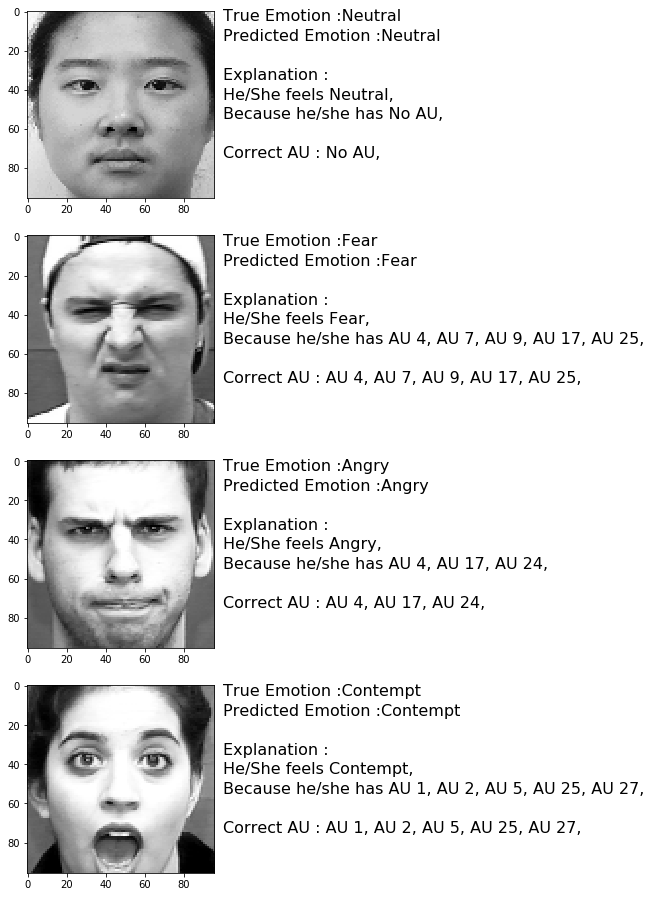

In [141]:
c = 1
plt.figure(figsize=(15,20))
for a in [3,4,7,9]:
    plt.subplot(5,1,c)
    plot_prediction(ax, a)
    c += 1
plt.savefig('justification_result.png')

In [51]:
facs_acc_percent = facs_accuracy.applymap(lambda x : x /262*100)

In [52]:
facs_acc_percent = facs_acc_percent.T

In [53]:
facs_acc_percent.columns = ['Accuracy']

In [54]:
facs_pred_df = pd.DataFrame(facs_pred_np, columns=facs.columns)

In [55]:
facs_test_arranged = facs_test.astype(np.int)
facs_test_arranged.index = range(facs_test_arranged.shape[0])

In [56]:
from sklearn.metrics import f1_score
facs_f1_score = {}
for code_num in facs_pred_df.columns:    
    facs_f1_score[int(code_num)] = f1_score(facs_test_arranged[code_num], facs_pred_df[code_num])

In [57]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
facs_precision = {}
for code_num in facs_pred_df.columns:    
    facs_precision[int(code_num)] = precision_score(facs_test_arranged[code_num], facs_pred_df[code_num])

facs_precision = pd.DataFrame(facs_precision, index=['precision'])

facs_precision = facs_precision.T

facs_acc_percent['Precision'] = facs_precision['precision'].map(lambda x : x * 100)

In [58]:
facs_f1_score = pd.DataFrame(facs_f1_score, index=['f1_score'])

facs_f1_score = facs_f1_score.T

facs_acc_percent['f1_score'] = facs_f1_score['f1_score'].map(lambda x : x * 100)

In [59]:
facs_recall = {}
for code_num in facs_pred_df.columns:    
    facs_recall[int(code_num)] = recall_score(facs_test_arranged[code_num], facs_pred_df[code_num])

facs_recall = pd.DataFrame(facs_recall, index=['recall'])

facs_recall = facs_recall.T

facs_acc_percent['Recall'] = facs_recall['recall'].map(lambda x : x * 100)

In [60]:
facs_acc_percent

,Accuracy,Precision,f1_score,Recall
0,94.656489,87.323944,89.855072,92.537313
1,95.801527,98.717949,93.333333,88.505747
2,96.183206,95.161290,92.187500,89.393939
4,96.946565,97.058824,94.285714,91.666667
5,95.419847,91.525424,90.000000,88.524590
6,96.946565,95.918367,92.156863,88.679245
7,95.801527,89.189189,85.714286,82.500000
9,99.236641,100.000000,96.153846,92.592593
12,98.473282,100.000000,95.555556,91.489362
15,94.656489,100.000000,53.333333,36.363636


In [62]:
from sklearn.metrics import confusion_matrix

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

AU  0
[[186   9]
 [  5  62]]
AU  1
[[174   1]
 [ 10  77]]
AU  2
[[193   3]
 [  7  59]]
AU  4
[[188   2]
 [  6  66]]
AU  5
[[196   5]
 [  7  54]]
AU  6
[[207   2]
 [  6  47]]
AU  7
[[218   4]
 [  7  33]]
AU  9
[[235   0]
 [  2  25]]
AU  12
[[215   0]
 [  4  43]]
AU  15
[[240   0]
 [ 14   8]]
AU  17
[[195   5]
 [  6  56]]
AU  20
[[244   0]
 [  2  16]]
AU  23
[[231   4]
 [  5  22]]
AU  24
[[233   2]
 [  6  21]]
AU  25
[[148   1]
 [  2 111]]
AU  27
[[212   1]
 [  3  46]]


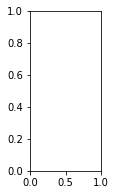

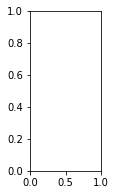

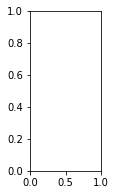

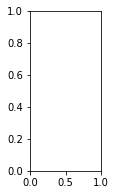

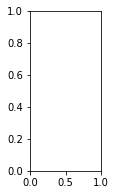

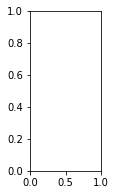

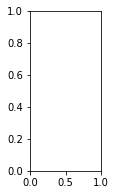

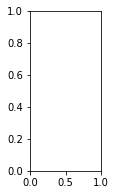

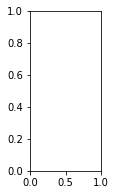

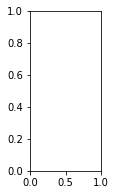

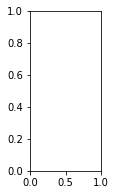

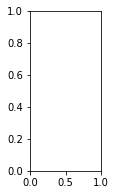

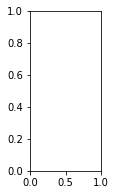

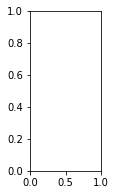

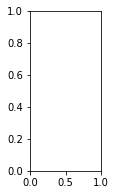

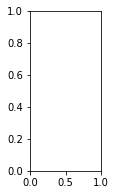

In [70]:
for index, code_num in enumerate(facs_pred_df.columns):
    plt.figure(figsize=(15,10))
    plt.subplot(3,10,index+1)

    print('AU ',code_num)
    print(confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num]))

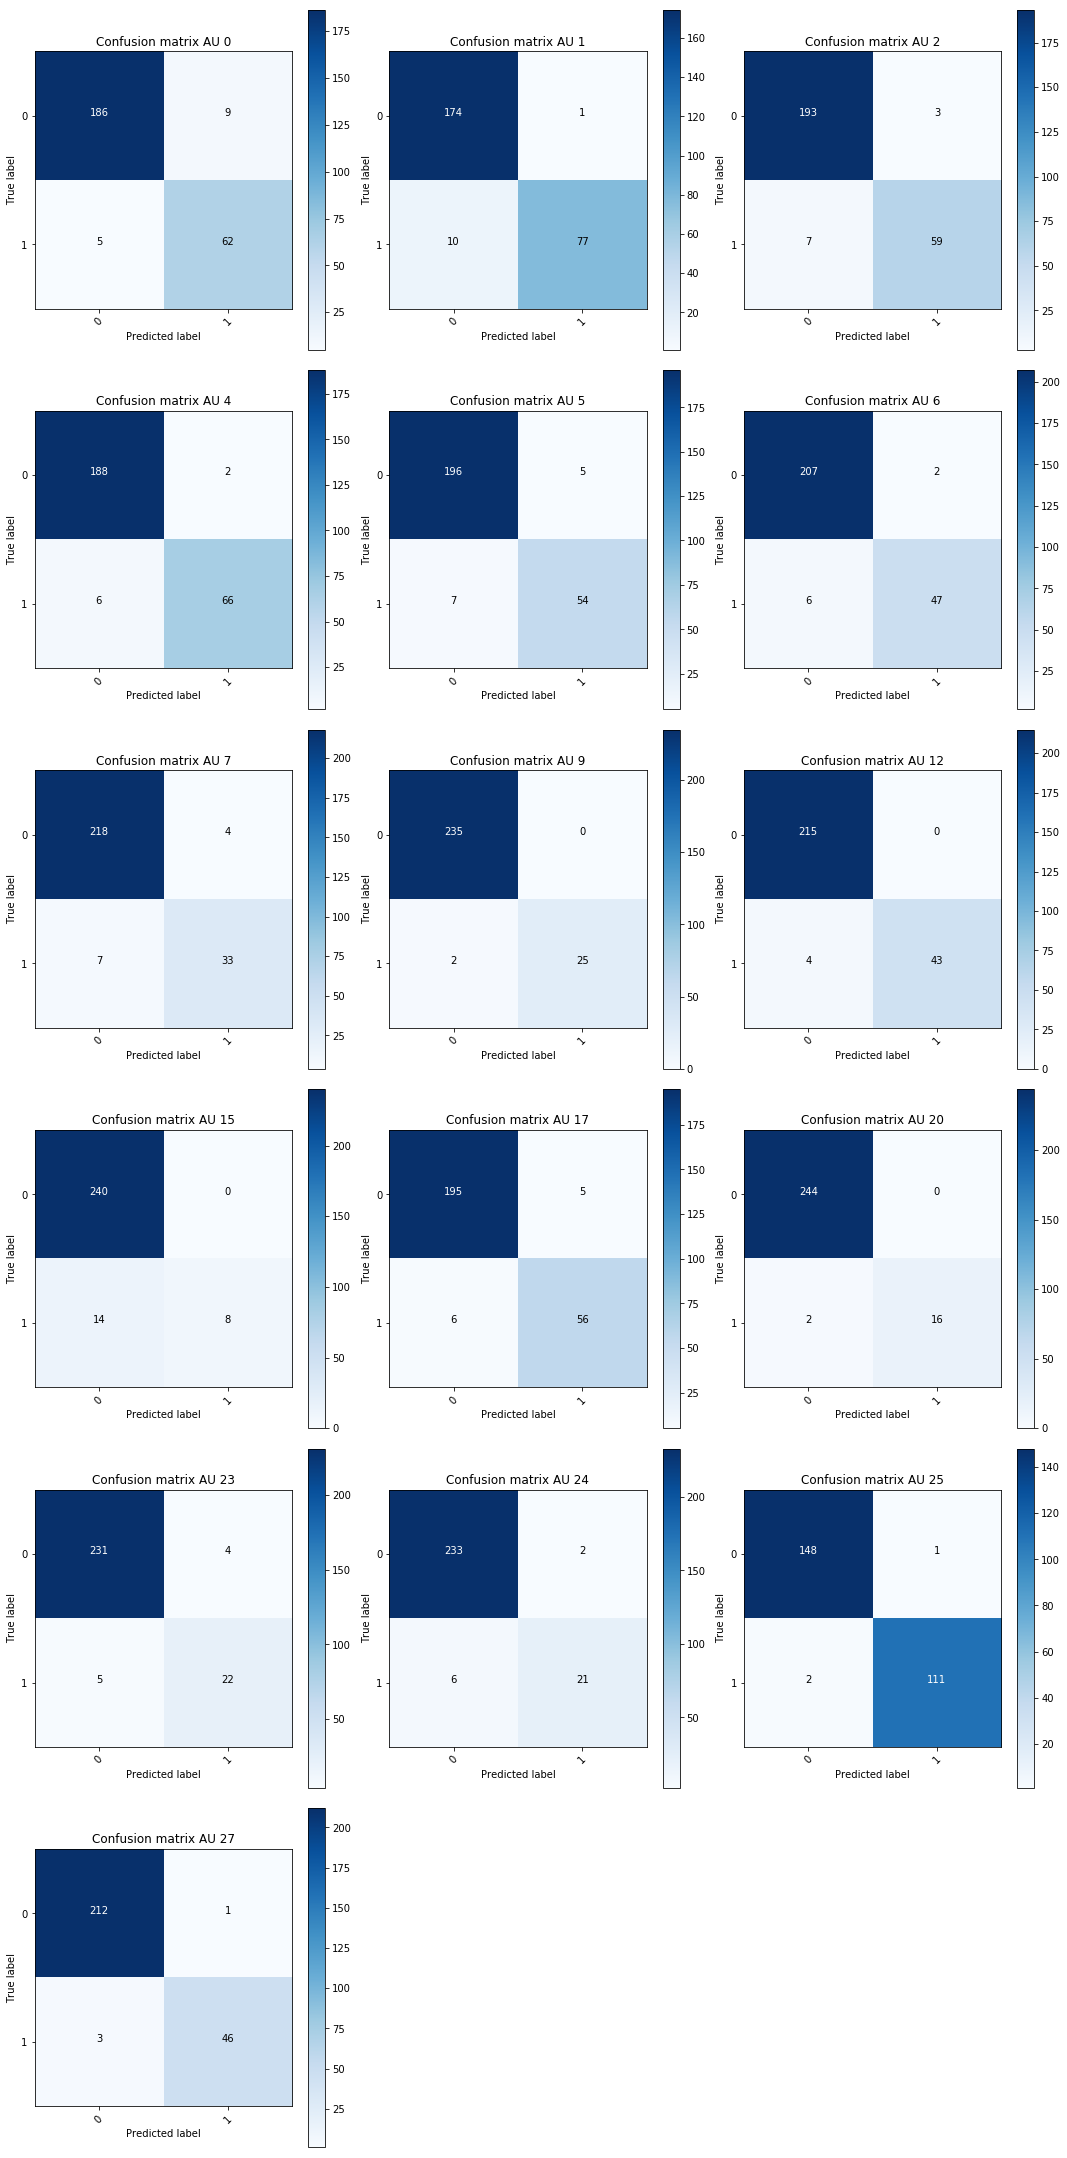

In [85]:
import itertools
class_names = [0, 1]
plt.figure(figsize=(15,50))
for index, code_num in enumerate(facs_pred_df.columns):
    plt.subplot(10,3,index+1)
    cnf_matrix = confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num])
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix AU '+str(code_num))

#     print('AU ',code_num)
#     print(confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num]))

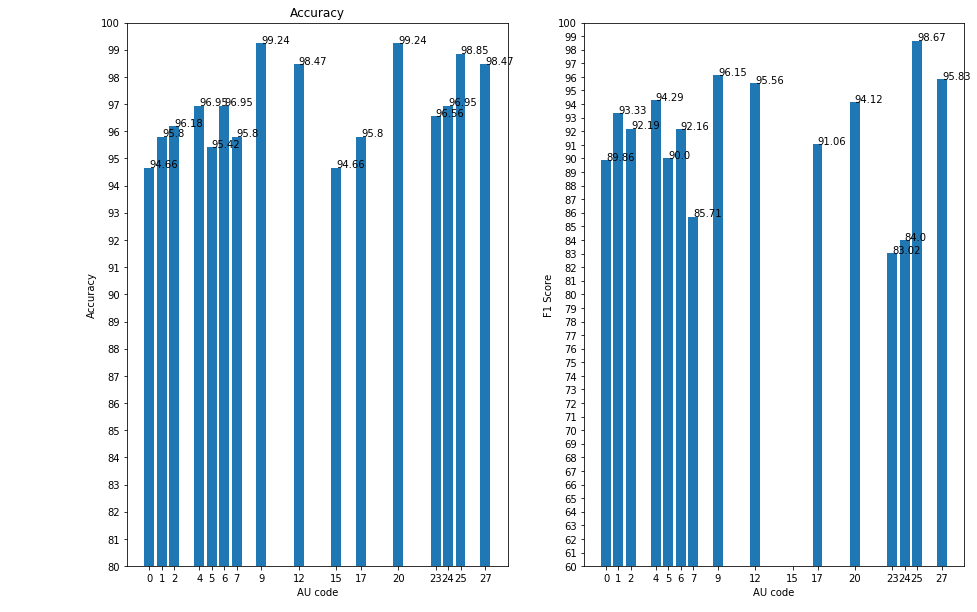

In [61]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('AU code')
plt.ylabel('Accuracy')
plt.xticks(facs_acc_percent.index)
plt.ylim((80,100))
plt.yticks(np.arange(80,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['Accuracy'])
for i,j in zip(list(facs_acc_percent.index), facs_acc_percent['Accuracy']):
    j = round(j, 2)
    ax.annotate(str(j),xy=(i,j))


ax = plt.subplot(1,2,2)
plt.xlabel('AU code')
plt.ylabel('F1 Score')
plt.xticks(facs_acc_percent.index)
plt.ylim((60,100))
plt.yticks(np.arange(60,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['f1_score'])
for i,j in zip(list(facs_acc_percent.index), facs_acc_percent['f1_score']):
    j = round(j, 2)
    ax.annotate(str(j),xy=(i,j))

In [213]:
facs_acc_percent.to_csv('result/feature_au_acc.csv')

<Container object of 18 artists>

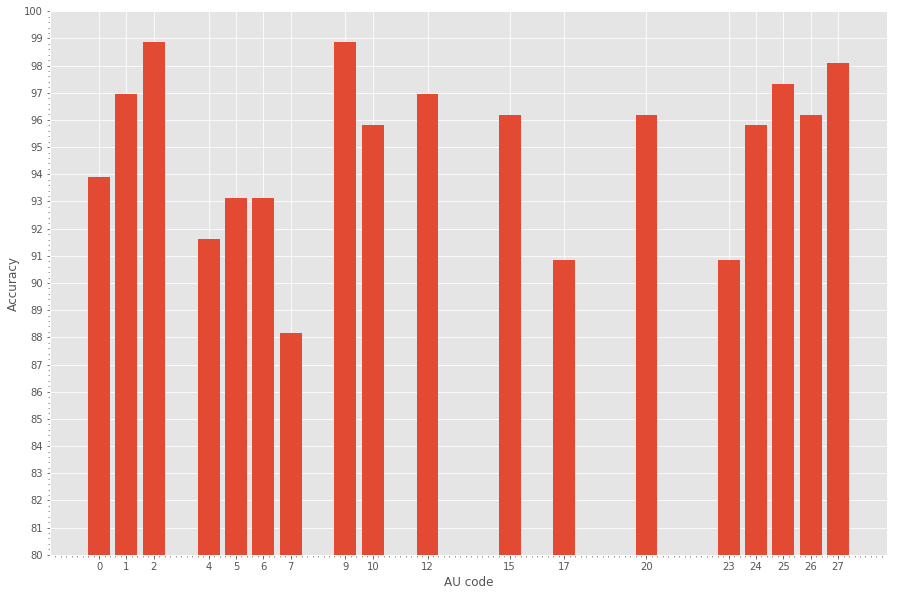

In [128]:
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
plt.ylabel('Accuracy')
plt.xlabel('AU code')
plt.minorticks_on()
plt.xticks(facs_acc_percent.index)
plt.ylim((80,100))
plt.yticks(np.arange(80,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['Accuracy'])

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
rfc = RandomForestClassifier()

In [59]:
rfc.fit(feature_train, facs_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
facs_pred = rfc.predict(feature_test)

In [67]:
facs_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [69]:
facs_test.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [75]:
correct = {}
for inst in range(facs_pred.shape[0]):
    for elem in range(facs_pred.shape[1]):
        if not elem in correct:
            correct[elem] = 0
        if facs_pred[inst][elem] == facs_test.values[inst][elem] and facs_pred[inst][elem] == 1:
            correct[elem] += 1
print(list(map(lambda x : x / facs_pred.shape[0], correct)))

[0.0, 0.003816793893129771, 0.007633587786259542, 0.011450381679389313, 0.015267175572519083, 0.019083969465648856, 0.022900763358778626, 0.026717557251908396, 0.030534351145038167, 0.03435114503816794, 0.03816793893129771, 0.04198473282442748, 0.04580152671755725, 0.04961832061068702, 0.05343511450381679, 0.05725190839694656, 0.061068702290076333, 0.0648854961832061]


## (300,)

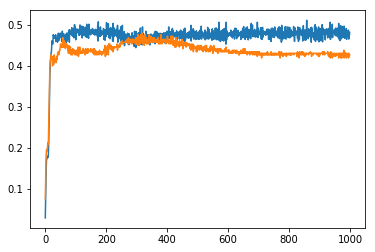

In [49]:
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000,)

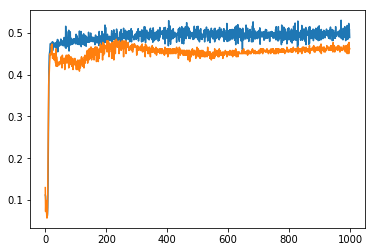

In [53]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000, 500)

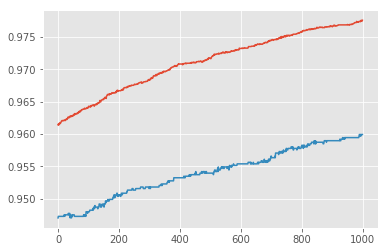

In [165]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

In [87]:
dense_model.predict(feature_test)

array([[2.18512014e-01, 5.77167809e-01, 7.63536572e-01, ...,
        5.63504756e-04, 9.23508763e-01, 2.13441402e-02],
       [9.82221782e-01, 1.37626287e-02, 2.53648125e-03, ...,
        3.66364897e-04, 1.48531352e-03, 6.00163010e-04],
       [8.52516592e-01, 7.67027810e-02, 1.06651649e-01, ...,
        5.03868284e-03, 1.97427981e-02, 5.98940812e-03],
       ...,
       [2.41851970e-03, 9.72193539e-01, 7.29454577e-01, ...,
        3.35017825e-03, 9.85902429e-01, 8.27229023e-03],
       [6.59153843e-03, 9.47243035e-01, 9.97439861e-01, ...,
        1.01467536e-04, 9.98487234e-01, 9.05066609e-01],
       [9.98491168e-01, 1.74474262e-03, 4.95835033e-04, ...,
        3.89486714e-03, 1.03251274e-04, 4.89191807e-05]], dtype=float32)